In [1]:
# Load Libraries and Set Print Options 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime as dt
import re

import plotly.express as px

import warnings

warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(230218)

# Set print options.

np.set_printoptions(precision=3)

plt.style.use("ggplot")  # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

In [2]:
# import the data
df_weights = pd.read_csv('all_weights.csv', index_col=0)
df_data = pd.read_csv('all_data.csv', index_col=0)

### Construct BBoss_ETF 

<div style="text-align: center;">
$$
BBoss_{ETF} = W_{1} \times \text{Index} + W_{2} \times \text{Big}_{10} + W_{3} \times \text{Best}_{10}
$$
</div>

<div style="text-align: center; margin-top: 20px;">
<span style="font-size: 14px;">where: W1 = 50%, W2 = 25%, W3 = 25%</span>
</div>


- Index {'a50'} = A-50 Index, but scaled down by 0.5X
- Big_10 {'size'} = 10 largest component Stocks by market value (in any one quarter), with an aggregate weighting within Index = A% (normally around 44%~48%). Each of Big 10 will have weightings a1 to a10 from the Index, and within the BBoss ETF, their weightings shall be (a(n)/A)*W2%.  
- Best_10 {'mom'} = 10 component Stocks with the highest expected growth in stock price, forecast using Momentum Indicators. For simplicity, each of Best 10 will have equal weightings b within the ETF, where b = W3/10 = 2.5%.
- Momentum Indicator used here is Simple Rate of Change = (Last Price - First Price)/First Price over entire quarter (lag = 60 days approx)
- However, for first training period, there were no prior training periods, so start with Best_10 based on historical price data in period = (q-1)
- Introduce a Moving Window to your training/test set for q1 to q24 where q1=2016Q2 and q28=2023Q1. The ETF_stats should exhibit outperformance until 2020Q1, and then underperformance from 2020Q2 onwards. You will end up with 28 train/test sets

In [3]:
# give a quarter name and get the last quarter stock infomation
# use the last quarter info to build our portfolio

def Train_get_data(quarter_number,df_weights,df_data):
    df = df_weights[df_weights["Time"] == quarter_number].reset_index(drop = True)
    train_start_date = df["Train_Start"].unique()[0]
    train_end_date = df["Train_End"].unique()[0]
    return df_data[df["code"]][(df_data.index >= train_start_date) 
                               & (df_data.index <= train_end_date)].sort_index(ascending = True).dropna()


# give a quarter name and get the current quarter to train our portfolio
def get_data(quarter_number,df_weights,df_data):
    df = df_weights[df_weights["Time"] == quarter_number].reset_index(drop = True)
    train_start_date = df["Start_Date"].unique()[0]
    train_end_date = df["End_Date"].unique()[0]
    return df_data[df["code"]][(df_data.index >= train_start_date) 
                               & (df_data.index <= train_end_date)].sort_index(ascending = True).dropna()


# get index data
def get_index(quarter_number,df_weights,df_data):
    df = df_weights[df_weights["Time"] == quarter_number].reset_index(drop = True)
    train_start_date = df["Start_Date"].unique()[0]
    train_end_date = df["Index_end"].unique()[0]
    return df_data["Price"][(df_data.index >= train_start_date) 
                               & (df_data.index <= train_end_date)].sort_index(ascending = True).dropna()


# define out portfolio
# three part --> index 50% + momentum 25% + size 25%

mom_number_comp = 10
size_number_comp = 10
dic_factor_weights = {"a50":0.5,"mom":0.25,"size":0.25}

def get_return(quarter_number,df_weights,df_data,
               mom_number_comp,size_number_comp,dic_factor_weights):
    
    df_train = Train_get_data(quarter_number,df_weights,df_data)
    df_test = get_data(quarter_number,df_weights,df_data)
    # get momentum indictor --> get the best 10
    df_mom = pd.DataFrame(df_train.apply(lambda x:(x[-1]-x[0])/x[0]),columns = ["weights"]).sort_values("weights",ascending = False).head(mom_number_comp)
    # get components
    df_quarter_weights = df_weights[["code","weight"]][df_weights["Time"] == quarter_number].set_index("code").sort_values("weight",ascending = False)
    
    # construct ETF --> our portfolio
    df_etf = pd.DataFrame()
    
    # calculate the first part --> index
    # then add into our portfolio
    df_a50 = pd.DataFrame()
    for name in df_quarter_weights.index:
        df_a50[name] = df_test[name].apply(lambda x: x*df_quarter_weights.loc[name])
    df_etf["a50"] = df_a50.sum(axis = 1)
    
    # calculate the second part --> momentum
    # then add into our portfolio
    mom = pd.DataFrame()
    mom_weight = 1/mom_number_comp
    for name in df_mom.index:
        mom[name] = df_test[name].apply(lambda x: x*mom_weight)
    df_etf["mom"] = mom.sum(axis = 1)
    
    # calculate the third part --> size
    # then add into our portfolio
    df_size = pd.DataFrame()
    size_total_weight = df_quarter_weights.head(size_number_comp).sum()
    for name in df_quarter_weights.head(size_number_comp).index:
        df_size[name] = df_test[name].apply(lambda x: x*df_quarter_weights.loc[name]/size_total_weight)
    df_etf["size"] = df_size.sum(axis = 1)
    
    # calculate our portfolio
    df_etf["portfolio"] = (dic_factor_weights["a50"] * df_etf["a50"] + 
                           dic_factor_weights["mom"] * df_etf["mom"] +
                           dic_factor_weights["size"] * df_etf["size"])
    df_etf["Returns"] = np.log(df_etf["a50"] / df_etf["a50"].shift(1))
    df_etf["Strategy_Returns"] = np.log(df_etf["portfolio"] / df_etf["portfolio"].shift(1))
    df_etf["Cum_Ret"] = df_etf["Returns"].cumsum().apply(np.exp)
    df_etf["Cum_Str"] = df_etf["Strategy_Returns"].cumsum().apply(np.exp)
    
    return df_etf
                   

<Axes: xlabel='Date'>

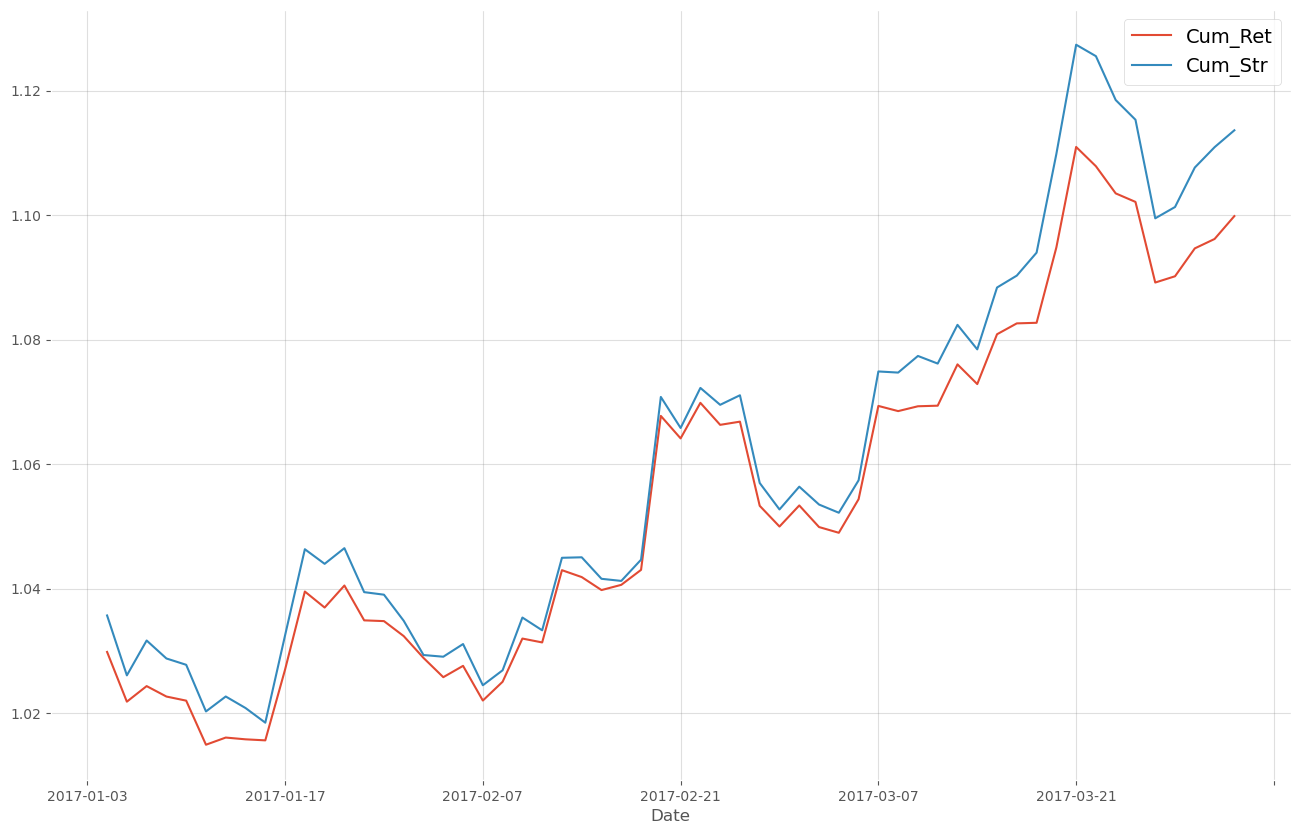

In [4]:
df_2016q2 = get_return("2017q1",df_weights,df_data,mom_number_comp,size_number_comp,dic_factor_weights)
df_2016q2[["Cum_Ret","Cum_Str"]].plot(figsize = (16,10))

2016q2
                  a50        mom       size  portfolio   Returns  \
Date                                                               
2016-04-01  18.472089  31.181899  26.218339  23.586104       NaN   
2016-04-05  18.550239  31.256780  26.282027  23.659822  0.004222   
2016-04-06  18.850994  32.245477  26.917826  24.216323  0.016083   
2016-04-07  18.602434  31.854726  26.591797  23.912848 -0.013273   
2016-04-08  18.404652  31.418275  26.270238  23.624455 -0.010689   
...               ...        ...        ...        ...       ...   
2016-06-24  19.226473  33.663246  27.875224  24.997854 -0.010401   
2016-06-27  19.749984  35.007475  28.783829  25.822818  0.026865   
2016-06-28  19.810144  35.082703  28.854696  25.889421  0.003041   
2016-06-29  19.898254  35.101058  28.953785  25.962838  0.004438   
2016-06-30  20.020532  35.473953  29.161737  26.169188  0.006126   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date                                              
2016-0

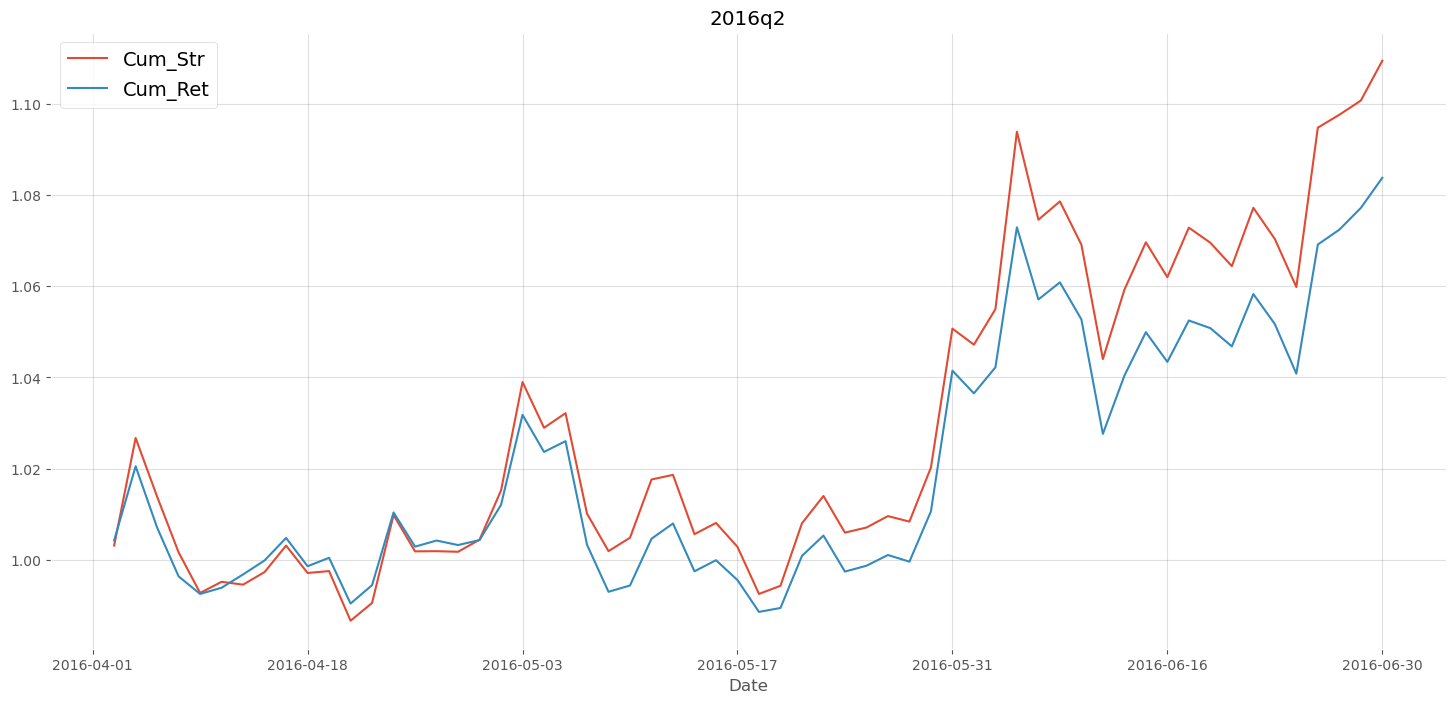

2016q3
                  a50        mom       size  portfolio   Returns  \
Date                                                               
2016-07-01  22.080137  45.094073  31.406747  30.165274       NaN   
2016-07-04  22.533388  46.183750  32.062599  30.828281  0.020320   
2016-07-05  22.772086  46.802504  32.506812  31.213372  0.010537   
2016-07-06  23.416106  48.920868  33.649920  32.350750  0.027889   
2016-07-07  23.399072  48.662963  33.636311  32.274354 -0.000728   
...               ...        ...        ...        ...       ...   
2016-09-26  22.626422  45.050192  32.245926  30.637240 -0.021562   
2016-09-27  22.761265  45.400735  32.450741  30.843501  0.005942   
2016-09-28  22.610246  45.074340  32.184741  30.619893 -0.006657   
2016-09-29  22.758242  45.479307  32.400924  30.849179  0.006524   
2016-09-30  23.039845  46.283080  32.889326  31.313024  0.012298   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date                                              
2016-0

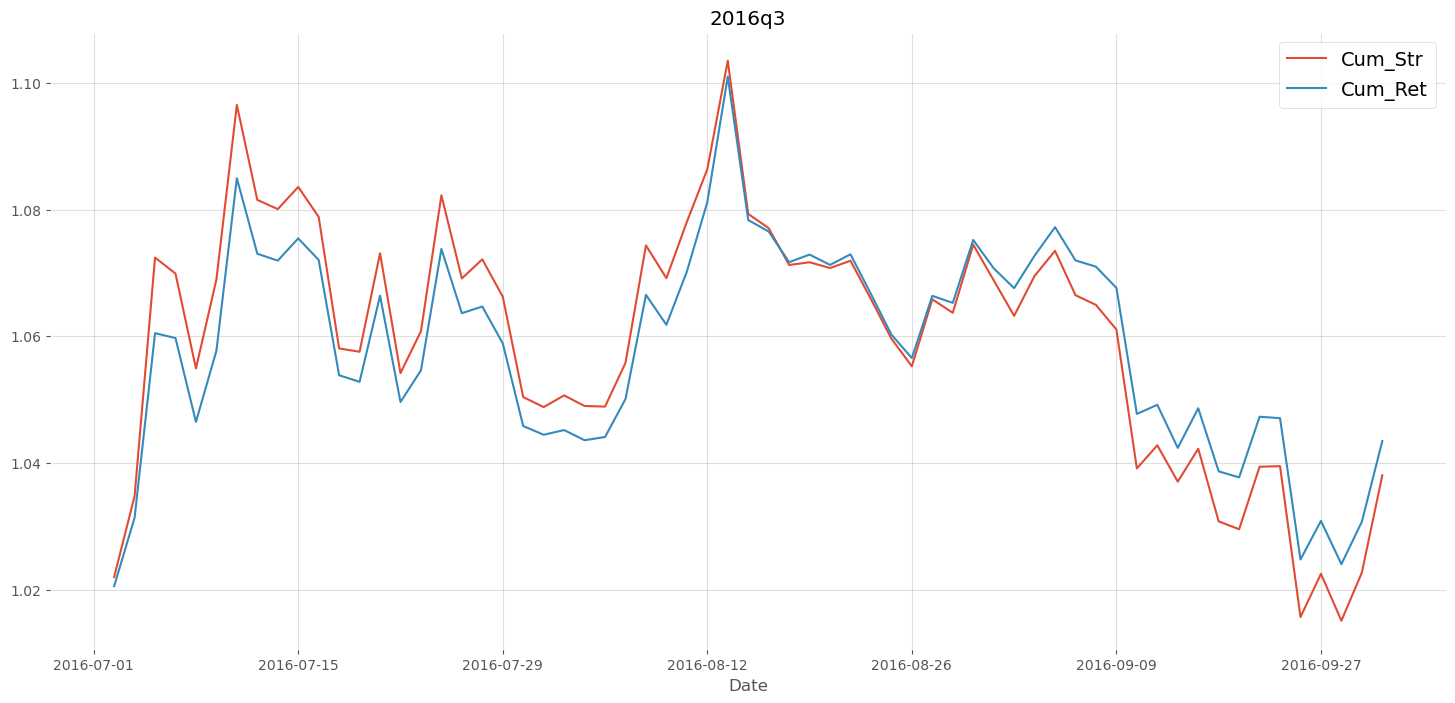

2016q4
                  a50        mom       size  portfolio   Returns  \
Date                                                               
2016-10-10  22.518869  11.576220  33.145225  22.439796       NaN   
2016-10-11  22.737664  11.615657  33.544786  22.658943  0.009669   
2016-10-12  22.605391  11.698305  33.278381  22.546867 -0.005834   
2016-10-13  22.509693  11.667000  33.104449  22.447709 -0.004242   
2016-10-14  22.587393  11.694948  33.248500  22.529558  0.003446   
2016-10-17  22.382857  11.557903  32.940561  22.316044 -0.009097   
2016-10-18  22.704261  11.743651  33.370313  22.630622  0.014257   
2016-10-19  22.655080  11.789106  33.296606  22.598968 -0.002168   
2016-10-20  22.630572  11.848975  33.243731  22.588463 -0.001082   
2016-10-21  22.653054  11.950060  33.203291  22.614865  0.000993   
2016-10-24  22.875509  11.996345  33.529561  22.819231  0.009772   
2016-10-25  23.064639  11.979301  33.939729  23.012077  0.008234   
2016-10-26  23.041956  11.913918  33.9258

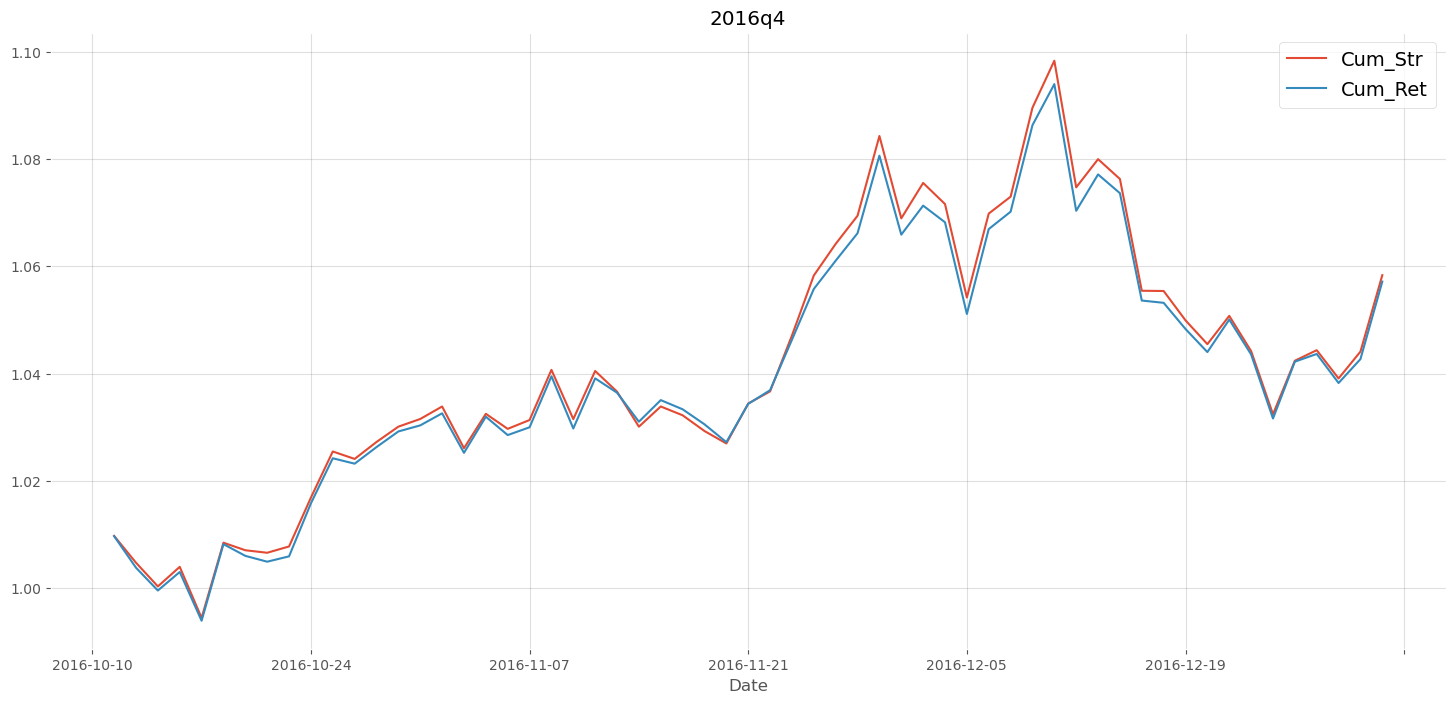

2017q1
                  a50        mom       size  portfolio   Returns  \
Date                                                               
2017-01-03  25.117014  38.200336  38.340163  31.693632       NaN   
2017-01-04  25.866454  39.843561  39.723374  32.824961  0.029401   
2017-01-05  25.665811  39.421410  39.327178  32.520053 -0.007787   
2017-01-06  25.728676  39.782960  39.549805  32.697529  0.002446   
2017-01-09  25.686538  39.670351  39.380668  32.606024 -0.001639   
2017-01-10  25.669975  39.563694  39.391763  32.573852 -0.000645   
2017-01-11  25.492195  39.262452  39.099041  32.336470 -0.006950   
2017-01-12  25.521085  39.382846  39.225032  32.412512  0.001133   
2017-01-13  25.513963  39.224758  39.162840  32.353881 -0.000279   
2017-01-16  25.509796  39.001539  39.095930  32.279265 -0.000163   
2017-01-17  25.795400  39.670482  39.634401  32.723920  0.011134   
2017-01-18  26.110119  40.256414  40.171692  33.162086  0.012127   
2017-01-19  26.045551  40.144497  40.1153

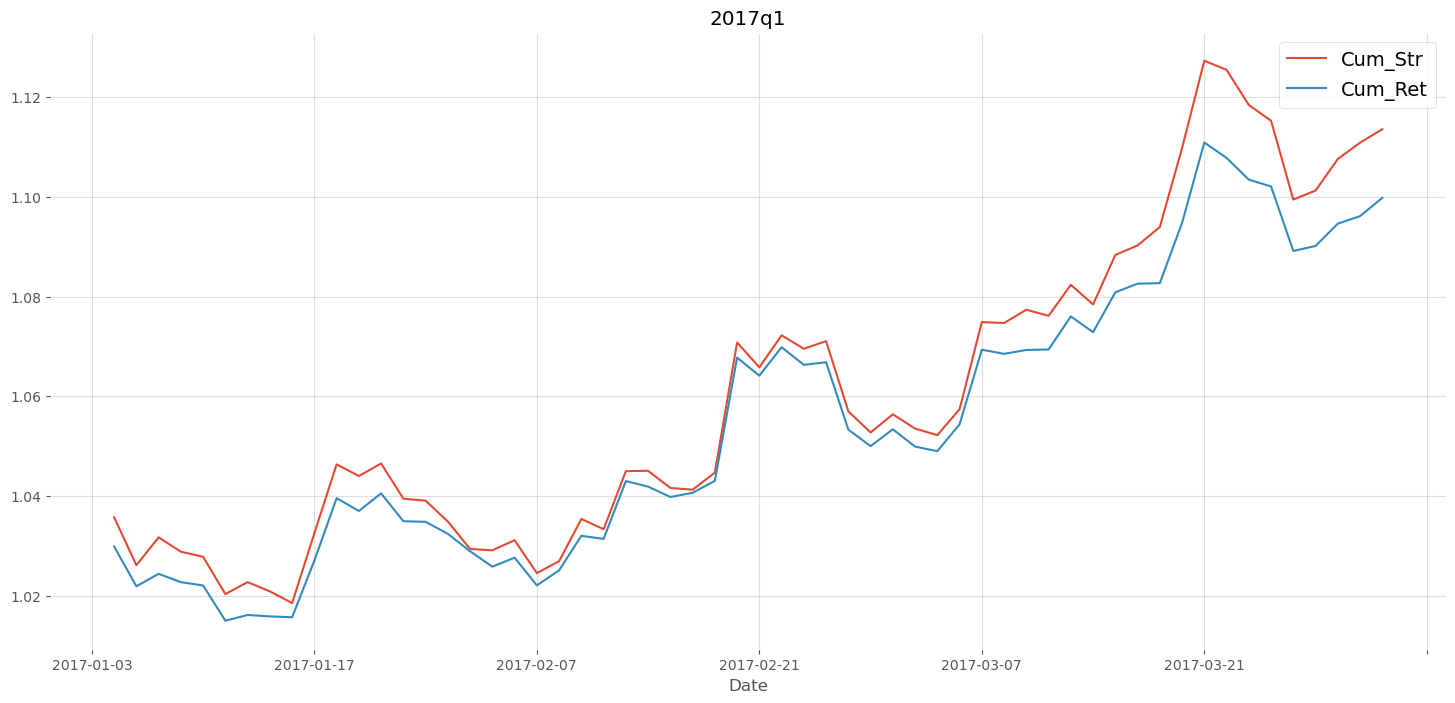

2017q2
                  a50        mom       size  portfolio   Returns  \
Date                                                               
2017-04-05  30.382281  56.978925  50.159433  41.975730       NaN   
2017-04-06  30.499273  57.206349  50.373394  42.144572  0.003843   
2017-04-07  30.493865  57.152906  50.384587  42.131306 -0.000177   
2017-04-10  30.243767  56.379936  49.955285  41.705689 -0.008235   
2017-04-11  30.066312  55.998484  49.519251  41.412590 -0.005885   
2017-04-12  30.297513  56.553015  49.941752  41.772448  0.007660   
2017-04-13  30.647461  57.522470  50.682561  42.374988  0.011484   
2017-04-14  30.425479  57.007395  50.341173  42.049882 -0.007269   
2017-04-17  30.482995  57.225707  50.436412  42.157027  0.001889   
2017-04-18  30.842258  58.477232  51.172751  42.833625  0.011717   
2017-04-19  30.840376  58.561986  51.197341  42.860020 -0.000061   
2017-04-20  31.386942  59.969597  52.122209  43.716422  0.017567   
2017-04-21  30.810316  58.510483  50.8490

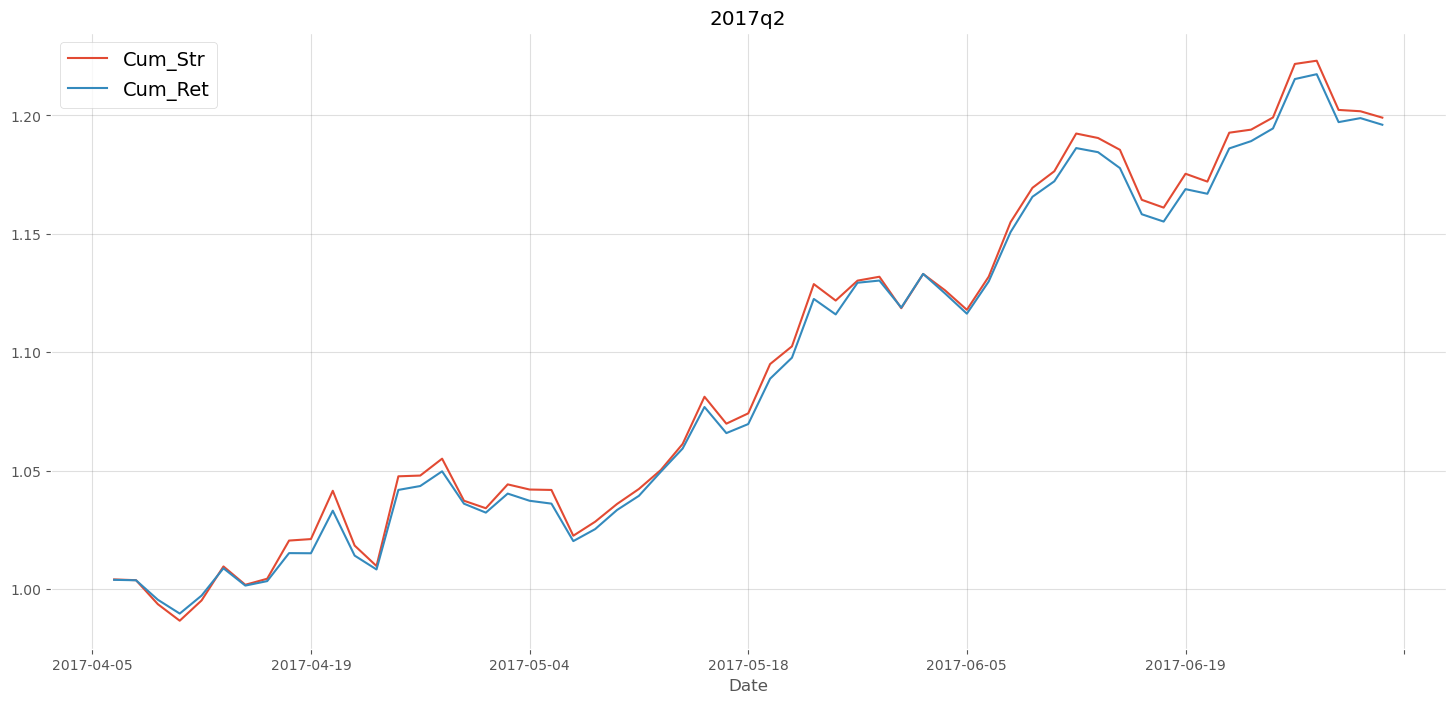

2017q3
                  a50        mom       size  portfolio   Returns  \
Date                                                               
2017-07-03  36.593805  69.591753  59.409103  50.547116       NaN   
2017-07-04  35.991594  68.358548  58.355226  49.674240 -0.016594   
2017-07-05  36.803292  70.105659  59.779027  50.872817  0.022302   
2017-07-06  36.735495  70.057509  59.594158  50.780664 -0.001844   
2017-07-07  36.449515  69.373856  59.100574  50.343365 -0.007815   
...               ...        ...        ...        ...       ...   
2017-09-25  40.505873  76.709499  66.031974  55.938305  0.008411   
2017-09-26  40.587935  76.767417  66.188735  56.033005  0.002024   
2017-09-27  40.450940  76.431212  65.971884  55.826244 -0.003381   
2017-09-28  40.945752  77.356993  66.880324  56.532206  0.012158   
2017-09-29  40.989162  77.403538  66.976939  56.589700  0.001060   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date                                              
2017-0

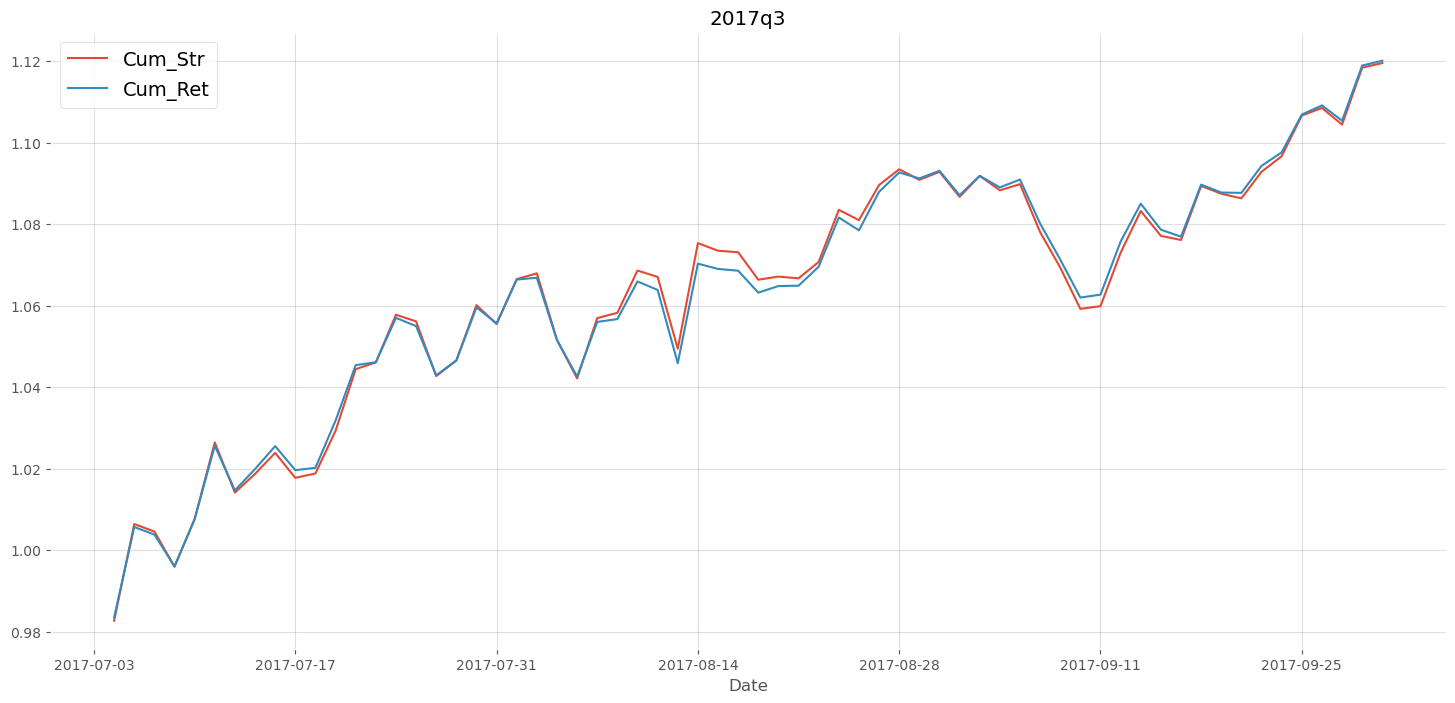

2017q4
                  a50        mom       size  portfolio   Returns  \
Date                                                               
2017-10-09  45.415107  75.705355  74.751207  60.321694       NaN   
2017-10-10  46.063537  76.703107  76.071874  61.225514  0.014177   
2017-10-11  46.538221  77.592816  76.719808  61.847266  0.010252   
2017-10-12  46.694936  77.421129  77.029502  61.960126  0.003362   
2017-10-13  47.296510  78.497119  78.196659  62.821699  0.012801   
2017-10-16  47.554446  78.843302  78.677250  63.157361  0.005439   
2017-10-17  47.469567  78.542669  78.510817  62.998155 -0.001786   
2017-10-18  47.956525  79.532660  79.202561  63.662068  0.010206   
2017-10-19  49.147820  81.906054  81.477431  65.419781  0.024538   
2017-10-20  48.562622  81.045898  80.425676  64.649204 -0.011978   
2017-10-23  48.576294  80.975463  80.428976  64.639257  0.000282   
2017-10-24  48.455130  80.505861  80.044879  64.365250 -0.002497   
2017-10-25  48.455972  80.270126  80.0065

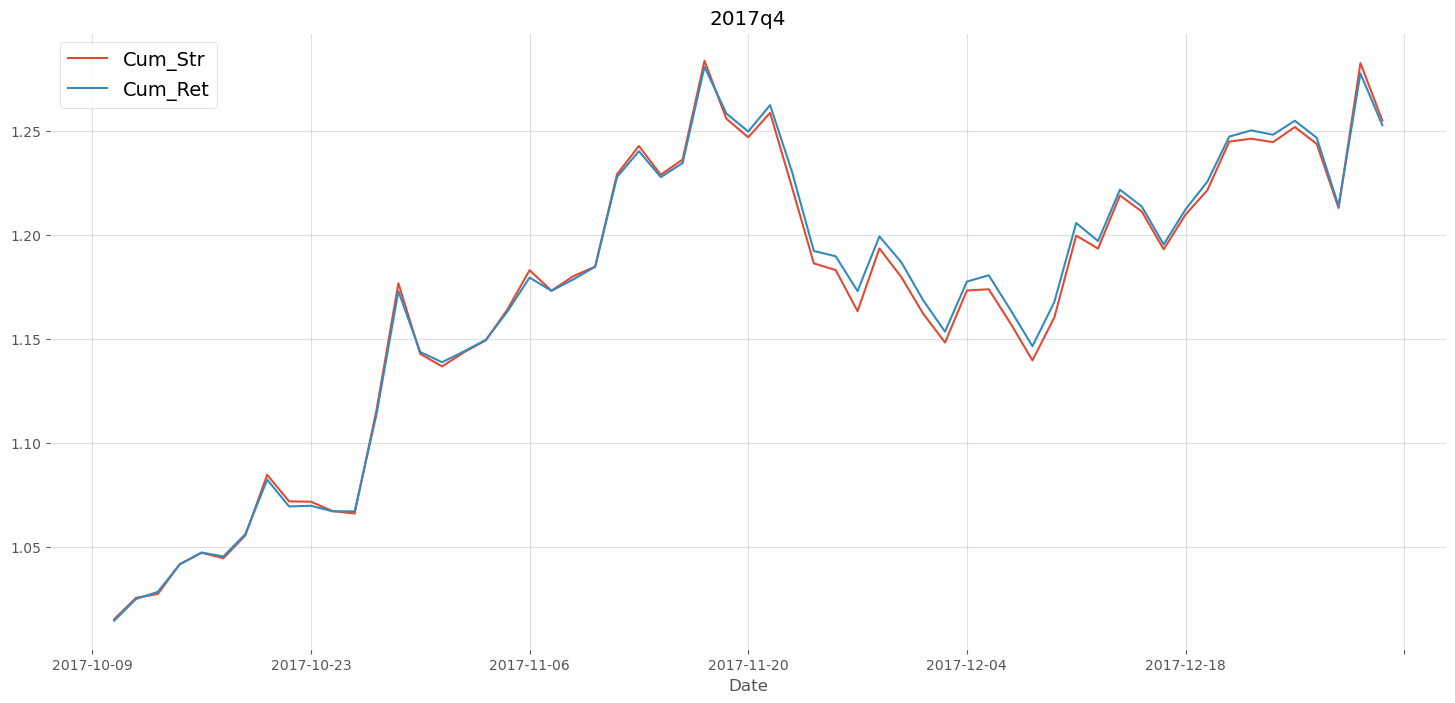

2018q1
                  a50         mom        size  portfolio   Returns  \
Date                                                                 
2018-01-02  58.835609   95.715699  101.015992  78.600727       NaN   
2018-01-03  59.283602   96.447157  101.955684  79.242511  0.007585   
2018-01-04  60.545383   98.659154  104.338959  81.022220  0.021060   
2018-01-05  60.700245   98.656286  104.628531  81.171327  0.002555   
2018-01-08  61.390787   99.695786  105.904799  82.095540  0.011312   
2018-01-09  63.376731  103.244949  109.600082  84.899623  0.031837   
2018-01-10  63.816519  103.868697  110.146002  85.411935  0.006915   
2018-01-11  63.247749  102.802028  109.103593  84.600280 -0.008953   
2018-01-12  64.358817  104.797782  111.055943  86.142840  0.017414   
2018-01-15  64.650684  105.154528  111.557380  86.503319  0.004525   
2018-01-16  64.141248  103.960896  110.527748  85.692785 -0.007911   
2018-01-17  62.623970  100.906771  107.729530  83.471060 -0.023940   
2018-01-18  6

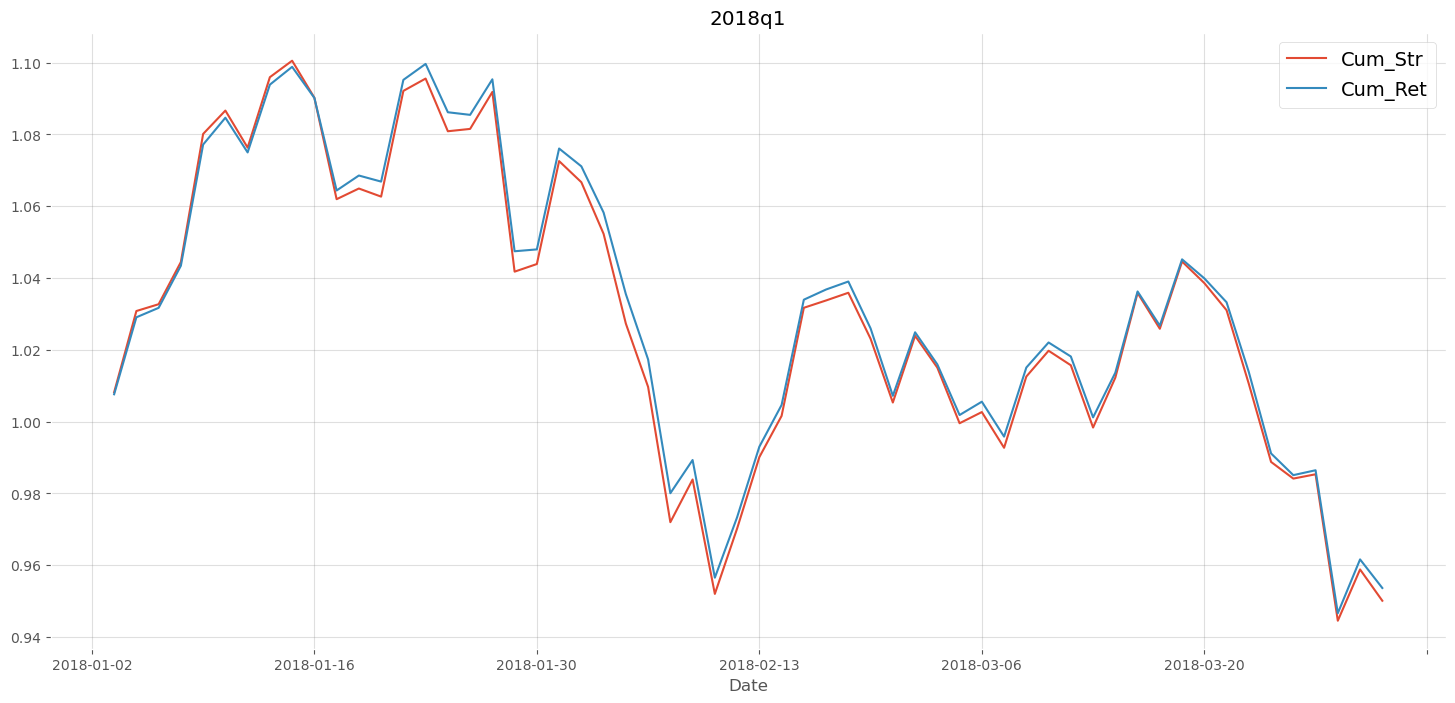

2018q2
                  a50        mom        size  portfolio   Returns  \
Date                                                                
2018-04-02  57.260368  20.603067  100.431838  58.888910       NaN   
2018-04-03  57.100475  20.573877  100.134955  58.727446 -0.002796   
2018-04-04  58.091458  20.579900  101.896727  59.664885  0.017206   
2018-04-09  58.315748  20.331886  102.409293  59.843169  0.003854   
2018-04-10  59.429773  20.773513  104.370305  61.000841  0.018923   
2018-04-11  59.277642  20.880976  104.053627  60.872472 -0.002563   
2018-04-12  58.394221  20.710804  102.424520  59.980942 -0.015015   
2018-04-13  57.764446  20.451236  101.371526  59.337914 -0.010843   
2018-04-16  56.984362  20.142745   99.947635  58.514776 -0.013597   
2018-04-17  55.850834  19.607677   97.979349  57.322174 -0.020092   
2018-04-18  55.373809  19.714139   96.923745  56.846376 -0.008578   
2018-04-19  57.102021  20.119630  100.112650  58.609080  0.030733   
2018-04-20  56.439945  20.0

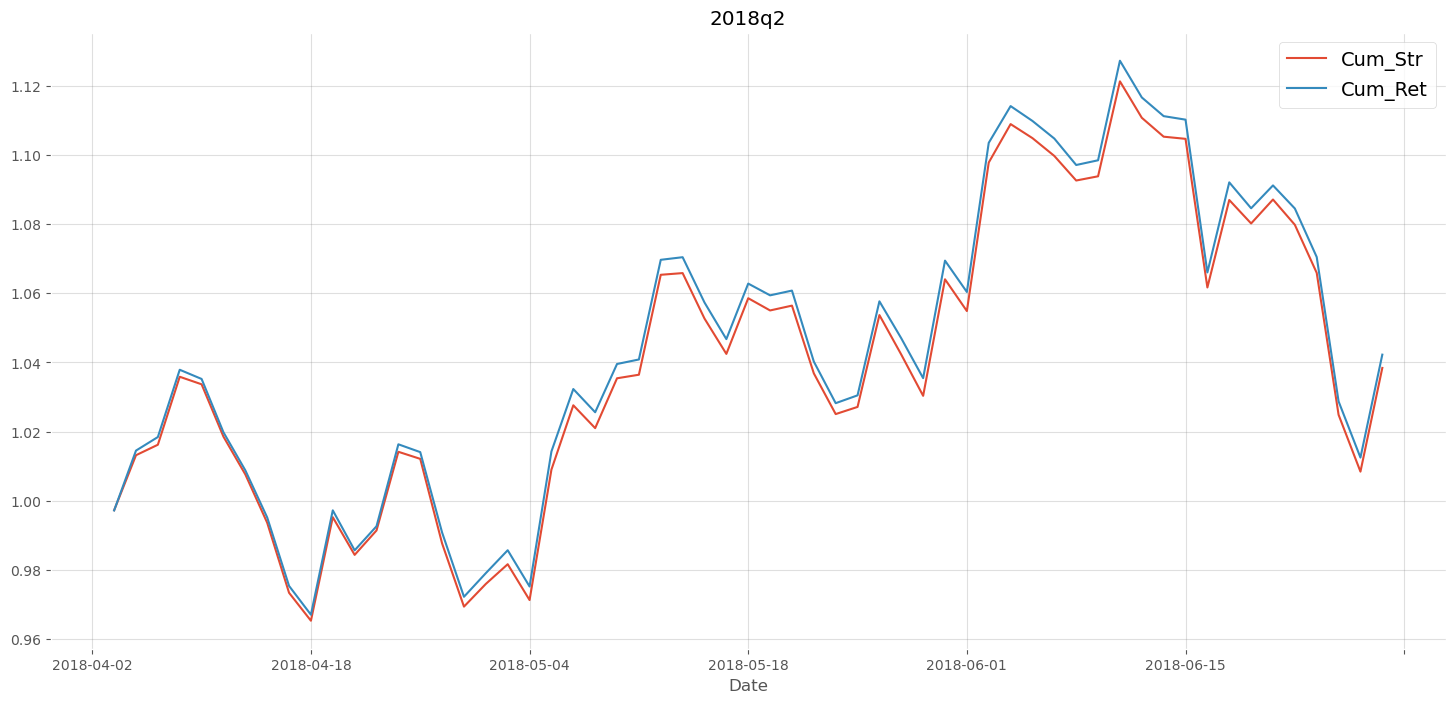

2018q3
                  a50        mom        size  portfolio   Returns  \
Date                                                                
2018-07-02  61.019288  14.301670  104.955382  60.323907       NaN   
2018-07-03  59.982443  14.074220  103.187756  59.306716 -0.017138   
2018-07-04  59.411130  13.989874  102.270806  58.770735 -0.009570   
2018-07-05  60.109411  13.887035  103.729201  59.458764  0.011685   
2018-07-06  61.141651  14.004495  105.569315  60.464278  0.017027   
...               ...        ...         ...        ...       ...   
2018-09-21  61.657489  14.066049  106.637423  61.004612  0.033872   
2018-09-25  61.262195  14.211472  106.018044  60.688476 -0.006432   
2018-09-26  63.174520  14.315820  109.540916  62.551444  0.030738   
2018-09-27  63.025223  14.319010  109.271360  62.410204 -0.002366   
2018-09-28  63.658985  14.551977  110.330270  63.050054  0.010005   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date                                        

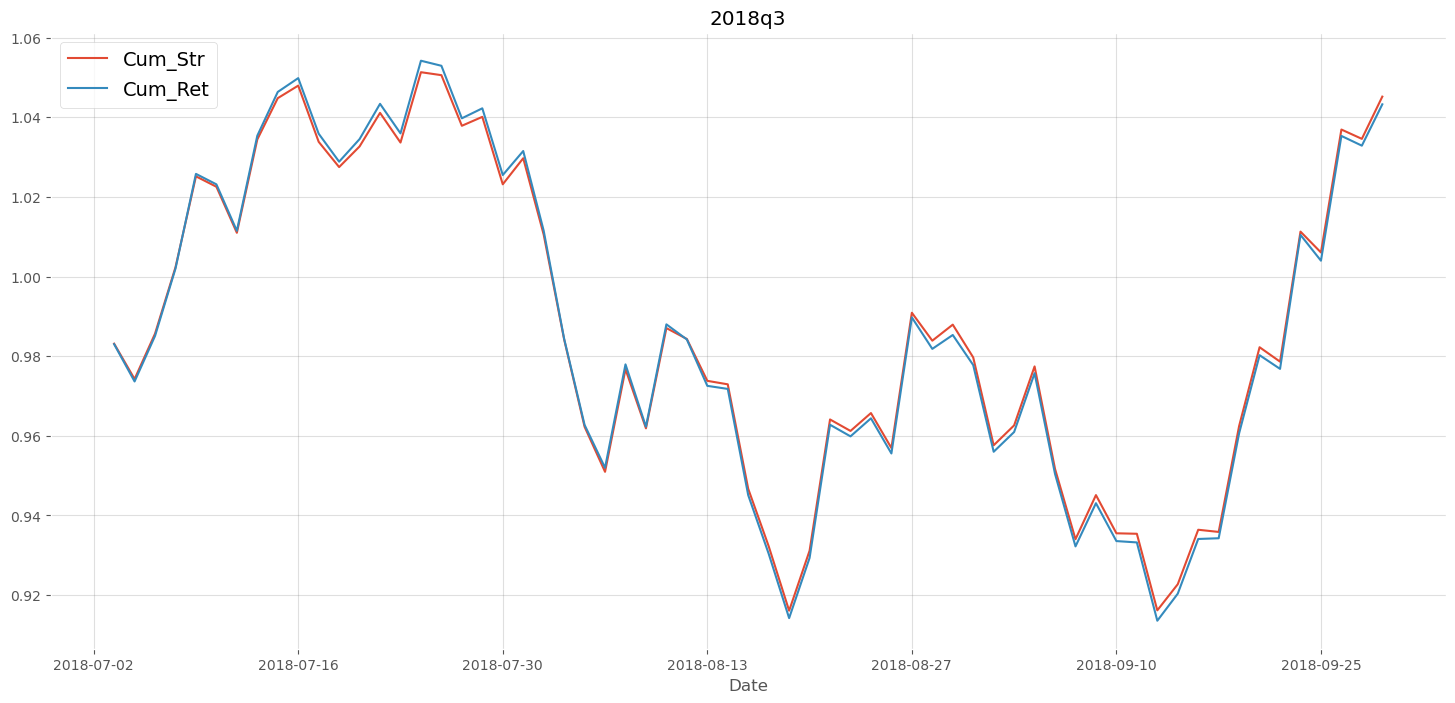

2018q4
                  a50        mom       size  portfolio   Returns  \
Date                                                               
2018-10-08  55.149502  19.490697  93.323961  55.778415       NaN   
2018-10-09  55.638944  19.558651  94.294462  56.282750  0.008836   
2018-10-10  54.295202  19.569056  91.823397  54.995714 -0.024448   
2018-10-11  52.211429  18.776174  88.314880  52.878478 -0.039134   
2018-10-12  53.926036  19.388043  91.299327  54.634861  0.032312   
2018-10-15  53.611571  19.119169  90.932353  54.318666 -0.005848   
2018-10-16  53.729359  19.341875  91.149060  54.487413  0.002195   
2018-10-17  53.718019  19.231079  91.081099  54.437054 -0.000211   
2018-10-18  52.209012  18.627209  88.484187  52.882355 -0.028493   
2018-10-19  54.200111  19.553967  91.898313  54.963125  0.037428   
2018-10-22  56.094610  20.270267  94.974174  56.858415  0.034357   
2018-10-23  52.848950  19.721887  89.103776  53.630891 -0.059602   
2018-10-24  52.637554  19.898883  88.9112

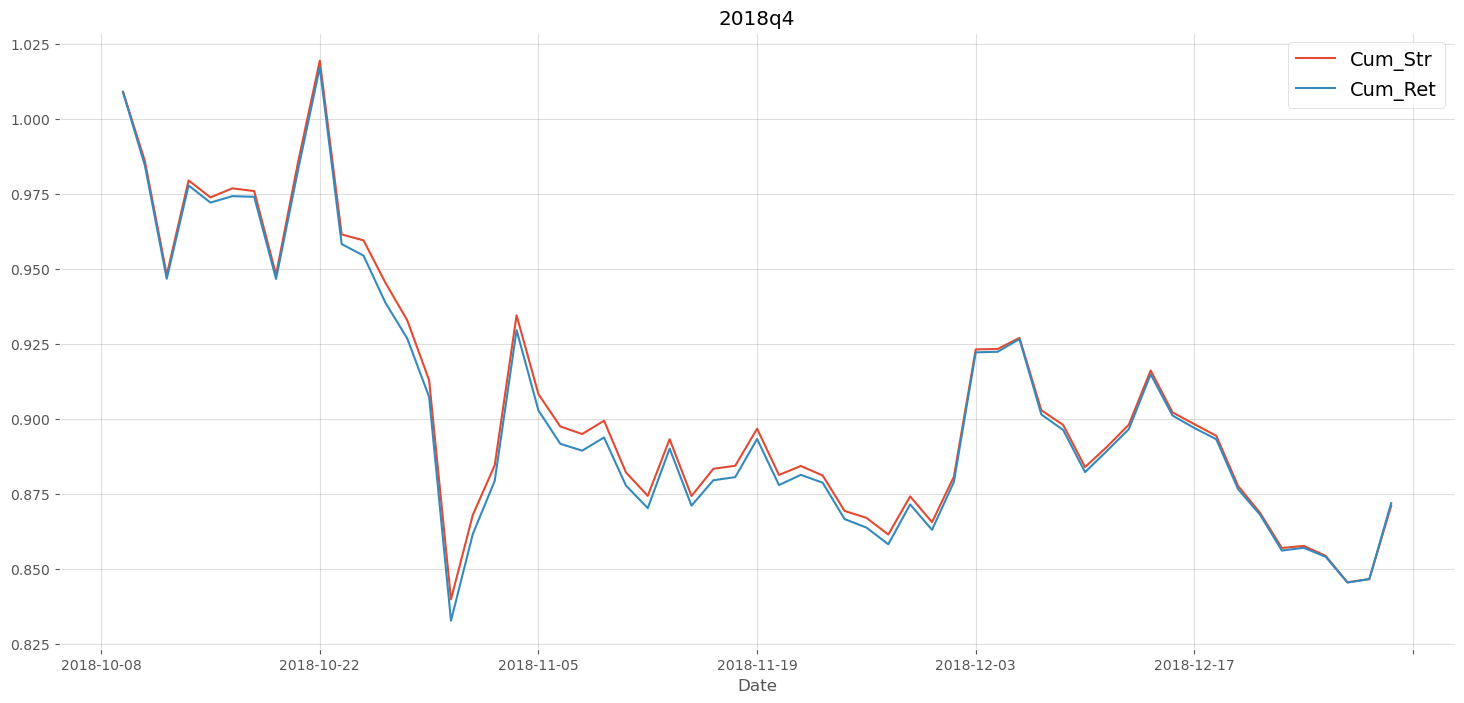

2019q1
                  a50        mom        size  portfolio   Returns  \
Date                                                                
2019-01-02  53.830778  12.449737   91.487588  52.899720       NaN   
2019-01-03  53.321140  12.552288   90.600044  52.448653 -0.009512   
2019-01-04  54.408152  12.959851   92.420536  53.549173  0.020181   
2019-01-07  54.569971  13.000598   92.763432  53.725993  0.002970   
2019-01-08  54.445206  13.090191   92.531761  53.628091 -0.002289   
2019-01-09  55.493430  13.031140   94.353370  54.592842  0.019070   
2019-01-10  55.715916  12.925544   94.843955  54.800333  0.004001   
2019-01-11  56.914730  12.915522   97.073715  55.954674  0.021288   
2019-01-14  56.015970  12.887372   95.505404  55.106179 -0.015917   
2019-01-15  58.637971  13.071887  100.167688  57.628879  0.045746   
2019-01-16  58.751559  13.059728  100.394997  57.739461  0.001935   
2019-01-17  58.560769  12.972274  100.043109  57.534231 -0.003253   
2019-01-18  60.421136  13.0

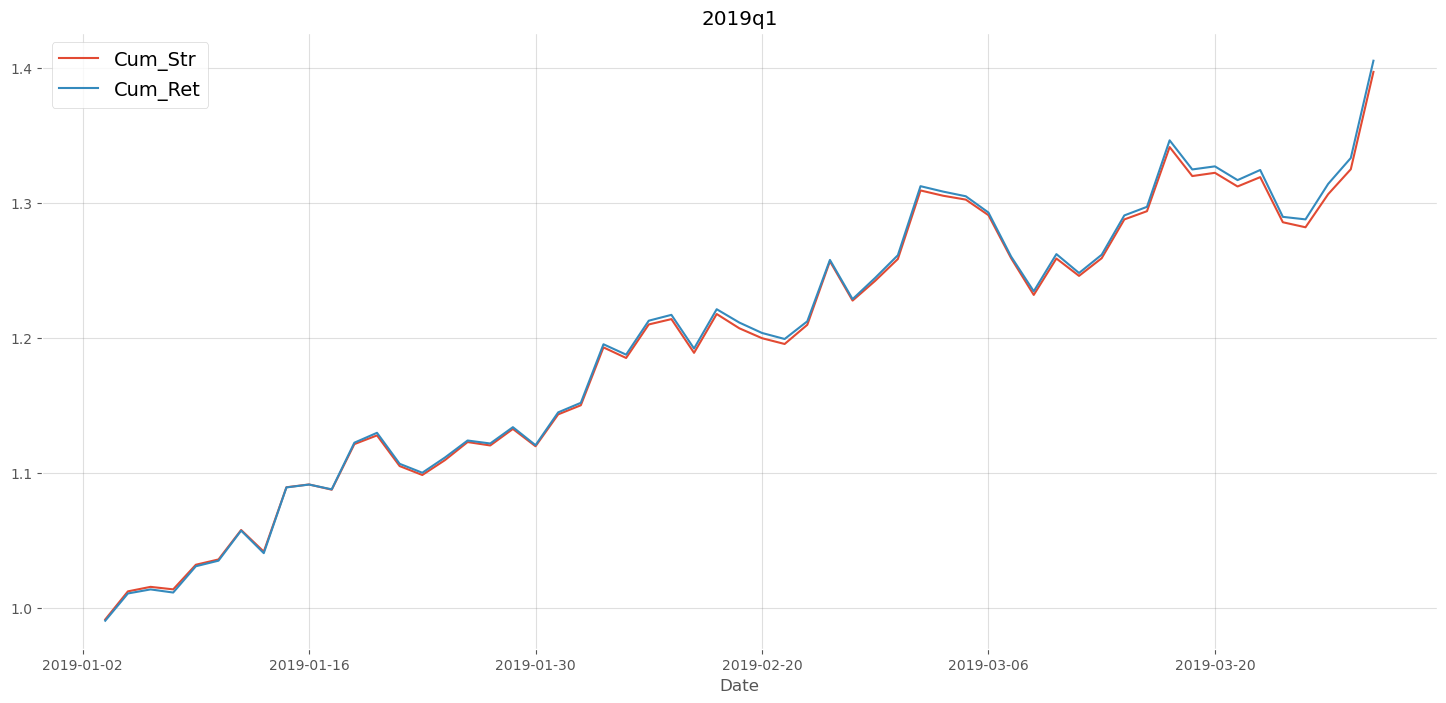

2019q2
                   a50         mom        size   portfolio   Returns  \
Date                                                                   
2019-04-01   88.214653  121.390620  149.082786  111.725678       NaN   
2019-04-02   87.535041  120.044644  147.948197  110.765731 -0.007734   
2019-04-03   87.366735  119.524177  147.533466  110.447778 -0.001925   
2019-04-04   89.168025  122.224885  150.721446  112.820595  0.020408   
2019-04-08   91.712920  125.301099  155.536213  116.065788  0.028141   
2019-04-09   92.569827  126.562525  157.029490  117.182917  0.009300   
2019-04-10   95.789316  130.695577  162.931205  121.301354  0.034188   
2019-04-11   93.427877  126.876597  158.920330  118.163170 -0.024961   
2019-04-12   92.520916  125.983277  157.227967  117.063269 -0.009755   
2019-04-15   92.249019  125.271280  156.748967  116.629571 -0.002943   
2019-04-16   95.478286  129.124926  162.365681  120.611795  0.034407   
2019-04-17   96.242430  130.327125  163.796276  121.65206

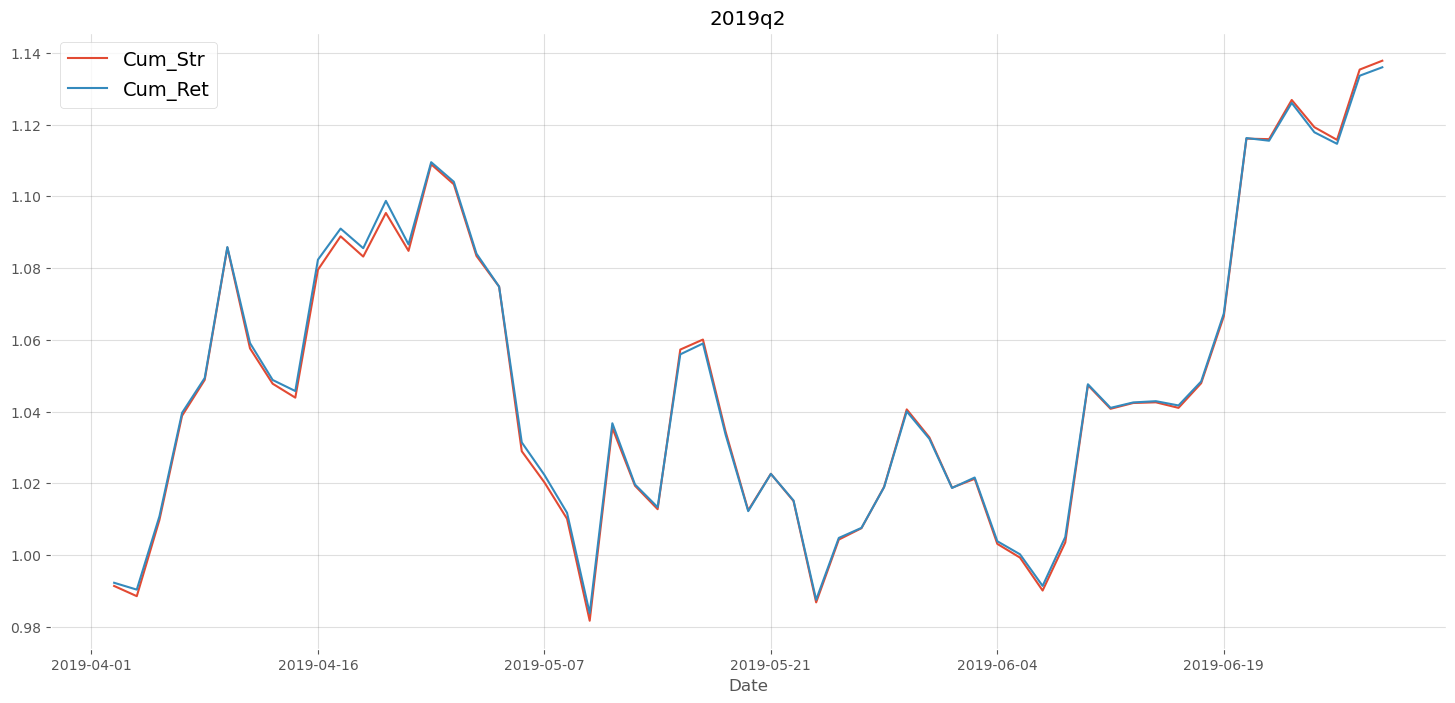

2019q3
                   a50         mom        size   portfolio   Returns  \
Date                                                                   
2019-07-01  121.937698  151.842929  204.014038  149.933091       NaN   
2019-07-02  121.422765  151.893573  202.992611  149.432928 -0.004232   
2019-07-03  117.767164  146.903653  196.664808  144.775698 -0.030569   
2019-07-04  116.949911  145.653889  195.329069  143.720695 -0.006964   
2019-07-05  119.103207  148.548326  199.092672  146.461853  0.018245   
...                ...         ...         ...         ...       ...   
2019-09-24  135.027760  168.647157  227.755774  166.614612  0.023380   
2019-09-25  134.109364  167.928109  226.149667  165.574126 -0.006825   
2019-09-26  133.361991  166.984242  224.836315  164.636135 -0.005588   
2019-09-27  133.987436  167.586592  225.969926  165.382847  0.004679   
2019-09-30  131.417383  164.295904  221.497900  162.157142 -0.019368   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date 

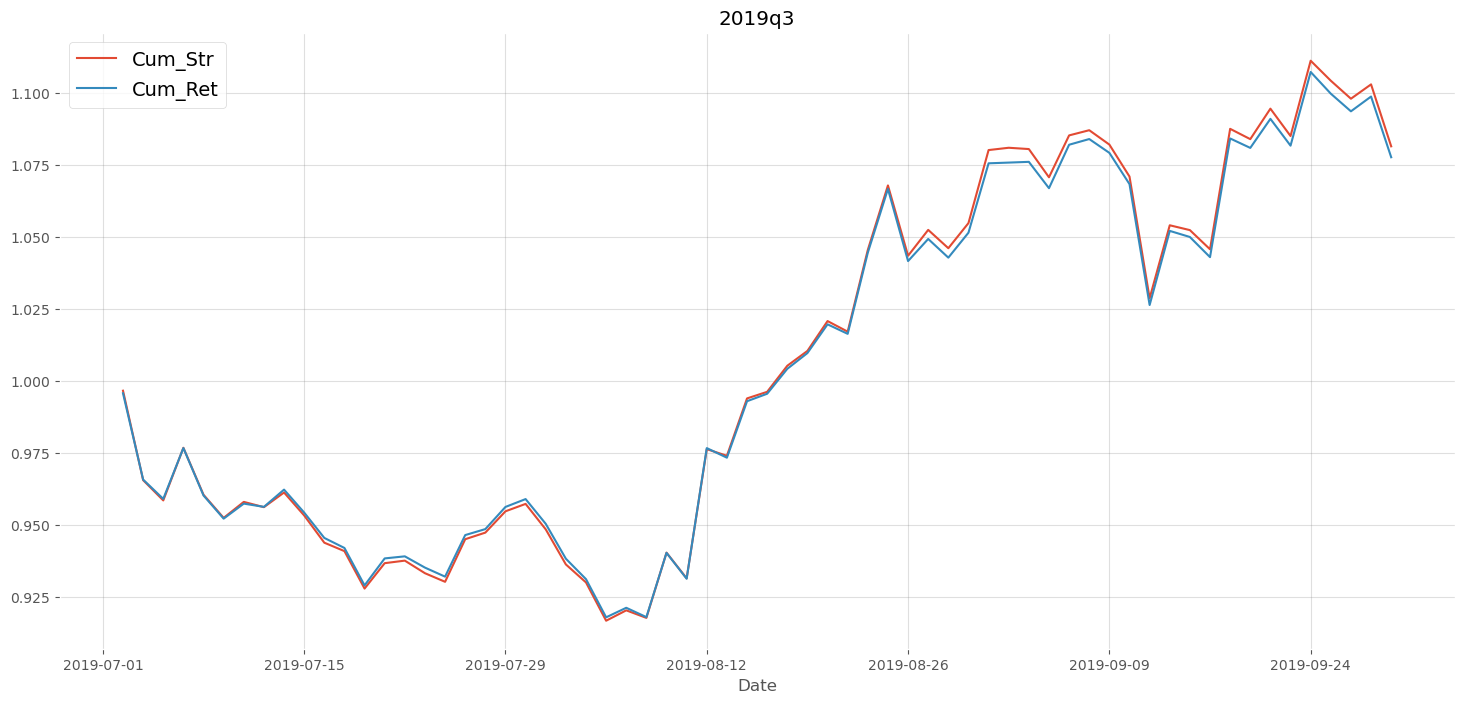

2019q4
                   a50         mom        size   portfolio   Returns  \
Date                                                                   
2019-10-08  132.237193  147.858325  217.538874  157.467897       NaN   
2019-10-09  130.410835  145.303288  214.415974  155.135233 -0.013907   
2019-10-10  131.288326  147.352481  215.852589  156.445430  0.006706   
2019-10-11  133.341289  149.171595  219.383406  158.809395  0.015516   
2019-10-14  133.979210  149.534962  220.429948  159.480832  0.004773   
...                ...         ...         ...         ...       ...   
2019-12-25  129.654080  144.298504  212.499405  154.026517 -0.010488   
2019-12-26  130.025817  144.991303  212.973527  154.504116  0.002863   
2019-12-27  132.394944  147.279706  217.250420  157.330004  0.018056   
2019-12-30  134.895906  149.846731  221.313157  160.237925  0.018714   
2019-12-31  134.681756  150.100352  220.893715  160.089395 -0.001589   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date 

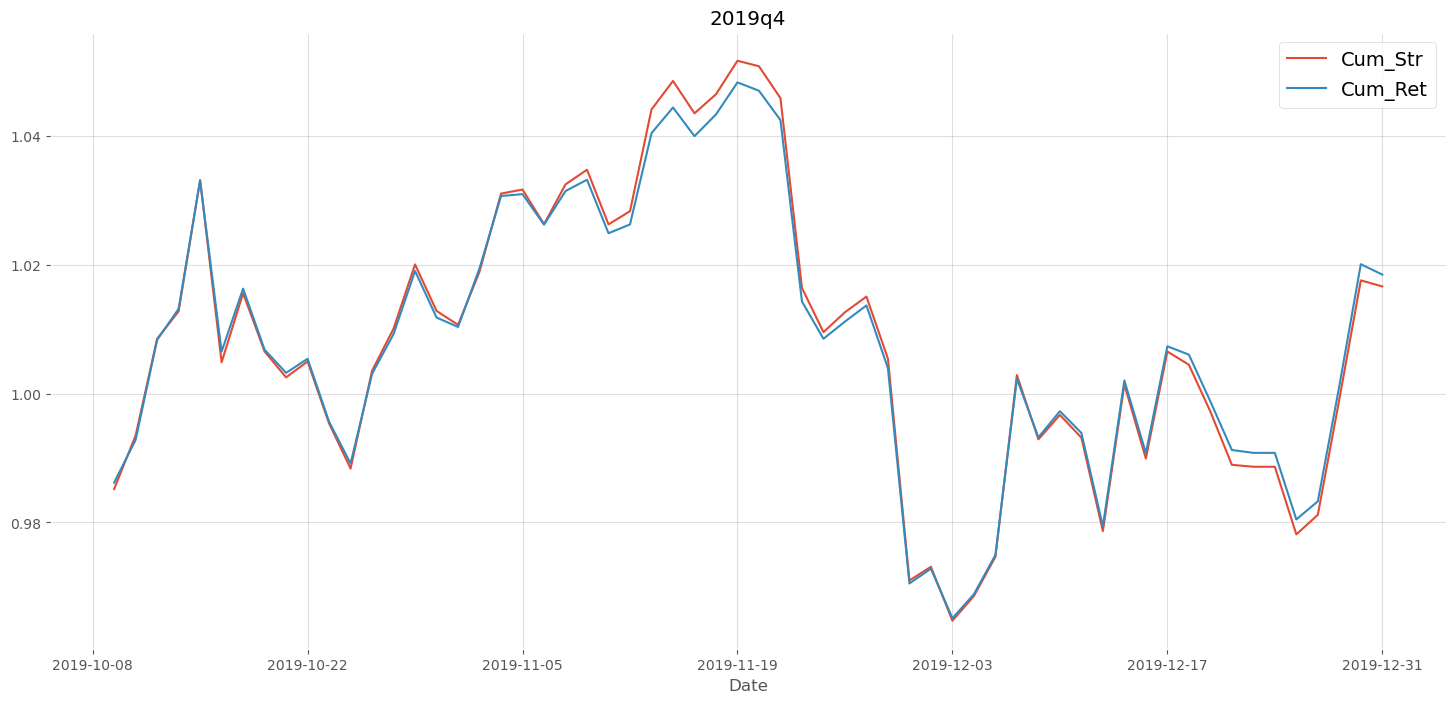

2020q1
                   a50        mom        size   portfolio   Returns  \
Date                                                                  
2020-01-02  122.475556  37.399112  202.022686  121.093227       NaN   
2020-01-03  118.415408  37.096475  194.655927  117.145805 -0.033713   
2020-01-06  117.991681  36.708754  194.139262  116.707845 -0.003585   
2020-01-07  119.555128  37.127569  196.733572  118.242850  0.013163   
2020-01-08  118.835585  37.030097  195.496432  117.549424 -0.006037   
2020-01-09  120.433947  37.894133  197.940867  119.175724  0.013361   
2020-01-10  121.237511  37.702498  199.448159  119.906420  0.006650   
2020-01-13  122.647627  38.137752  201.903044  121.334013  0.011564   
2020-01-14  121.208751  37.953755  199.438606  119.952466 -0.011801   
2020-01-15  121.429074  37.818453  199.829632  120.126558  0.001816   
2020-01-16  120.917386  37.549094  198.879226  119.565773 -0.004223   
2020-01-17  121.031581  37.465140  199.166182  119.673621  0.000944   

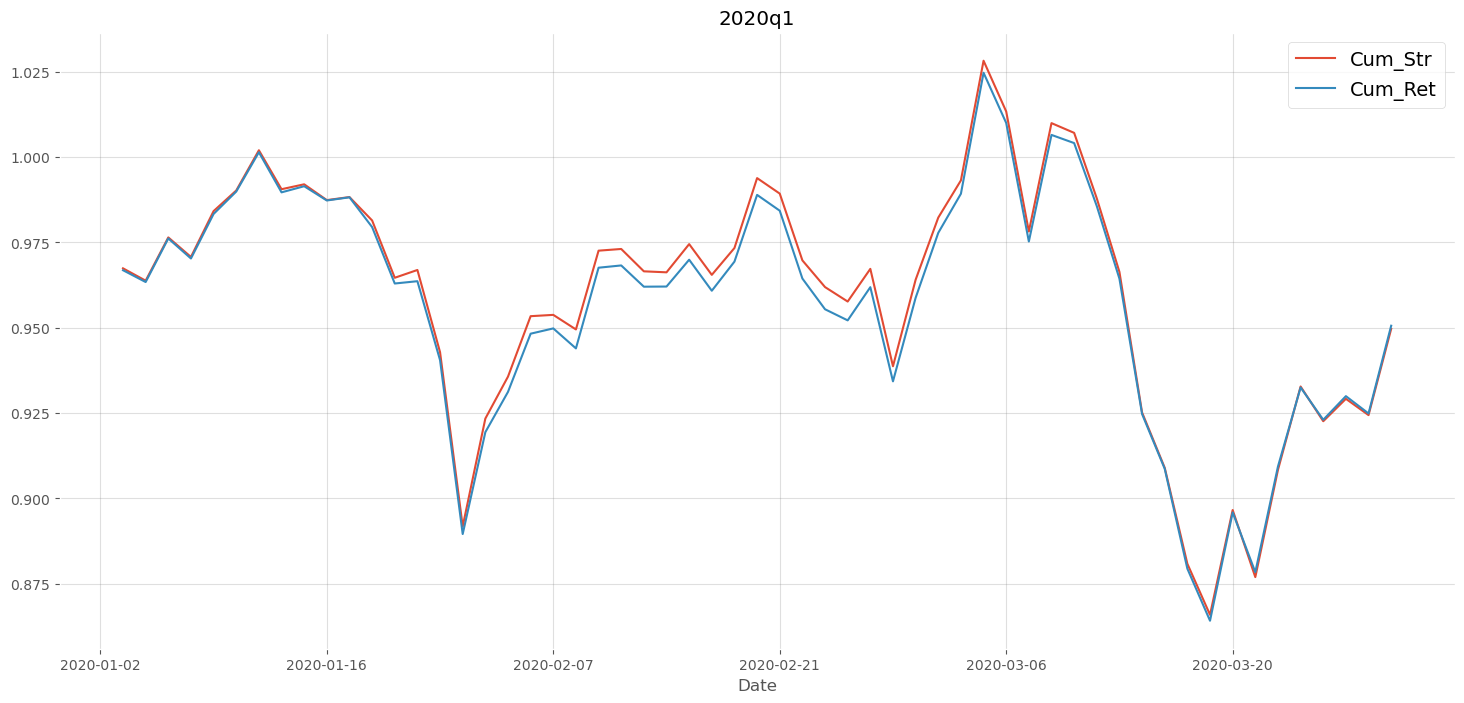

2020q2
                   a50        mom        size   portfolio   Returns  \
Date                                                                  
2020-04-01  134.187929  75.185085  225.426222  142.246792       NaN   
2020-04-02  138.475508  76.595465  233.020687  146.641792  0.031452   
2020-04-03  137.920026  76.730243  232.021791  146.148021 -0.004019   
2020-04-07  140.617823  79.028983  236.391630  149.164065  0.019372   
2020-04-08  140.426684  78.602922  236.176044  148.908084 -0.001360   
2020-04-09  140.436432  78.768122  236.097377  148.934591  0.000069   
2020-04-10  141.094773  76.741775  237.654356  149.146419  0.004677   
2020-04-13  140.737738  76.024825  237.069122  148.642356 -0.002534   
2020-04-14  143.409504  77.801858  241.623433  151.561075  0.018806   
2020-04-15  143.604630  78.347650  242.078097  151.908751  0.001360   
2020-04-16  144.182358  78.530067  243.179850  152.518658  0.004015   
2020-04-17  147.359364  79.323577  248.767604  155.702477  0.021795   

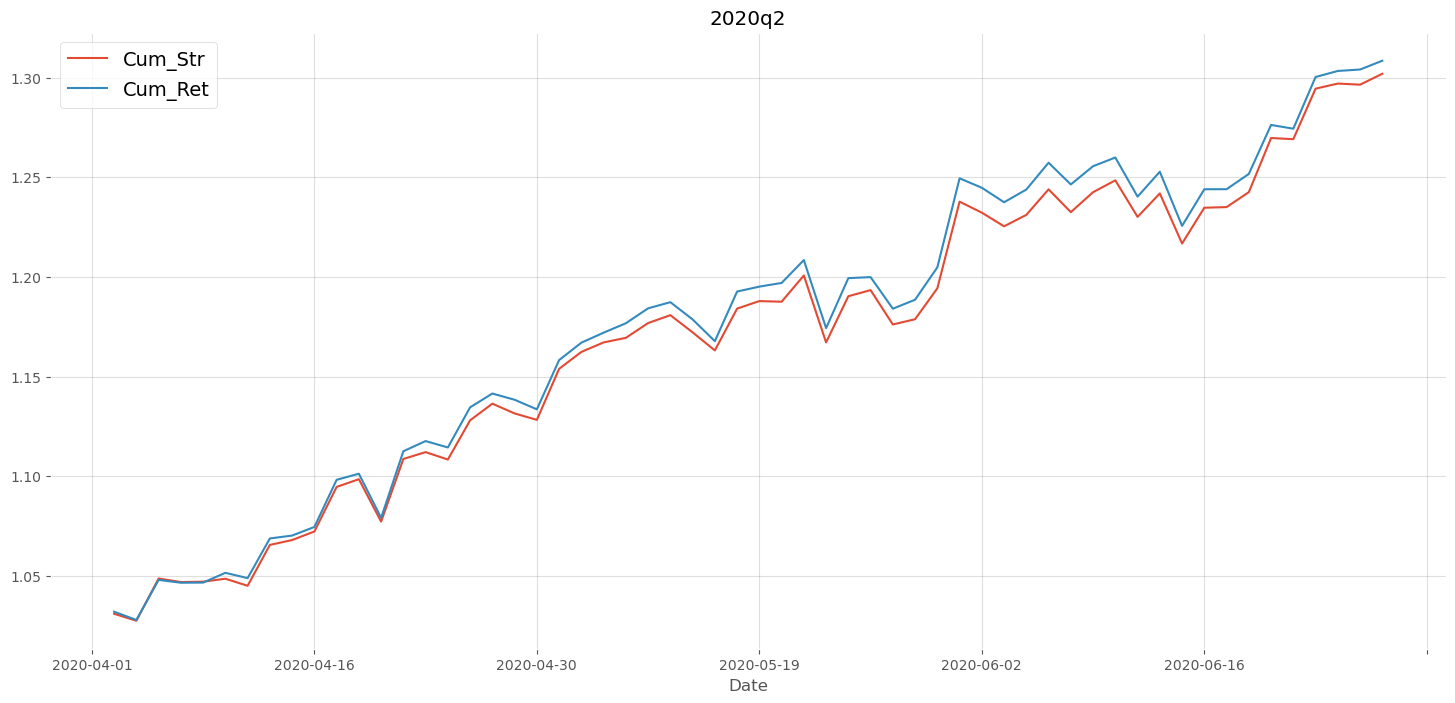

2020q3
                   a50         mom        size   portfolio   Returns  \
Date                                                                   
2020-07-01  216.783218  233.446563  354.921423  255.483606       NaN   
2020-07-02  223.362849  240.492842  366.585887  263.451107  0.029900   
2020-07-03  224.077704  242.117212  366.761701  264.258580  0.003195   
2020-07-06  233.161075  253.451991  381.245407  275.254887  0.039737   
2020-07-07  243.910147  263.299335  400.398167  287.879449  0.045070   
...                ...         ...         ...         ...       ...   
2020-09-24  237.657206  257.119351  387.869371  280.075783 -0.013491   
2020-09-25  238.530347  257.976847  389.244158  281.070425  0.003667   
2020-09-28  241.919594  261.507949  394.963355  285.077623  0.014109   
2020-09-29  241.012273  261.601761  392.939541  284.141462 -0.003758   
2020-09-30  242.967463  263.526596  396.224654  286.421544  0.008080   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date 

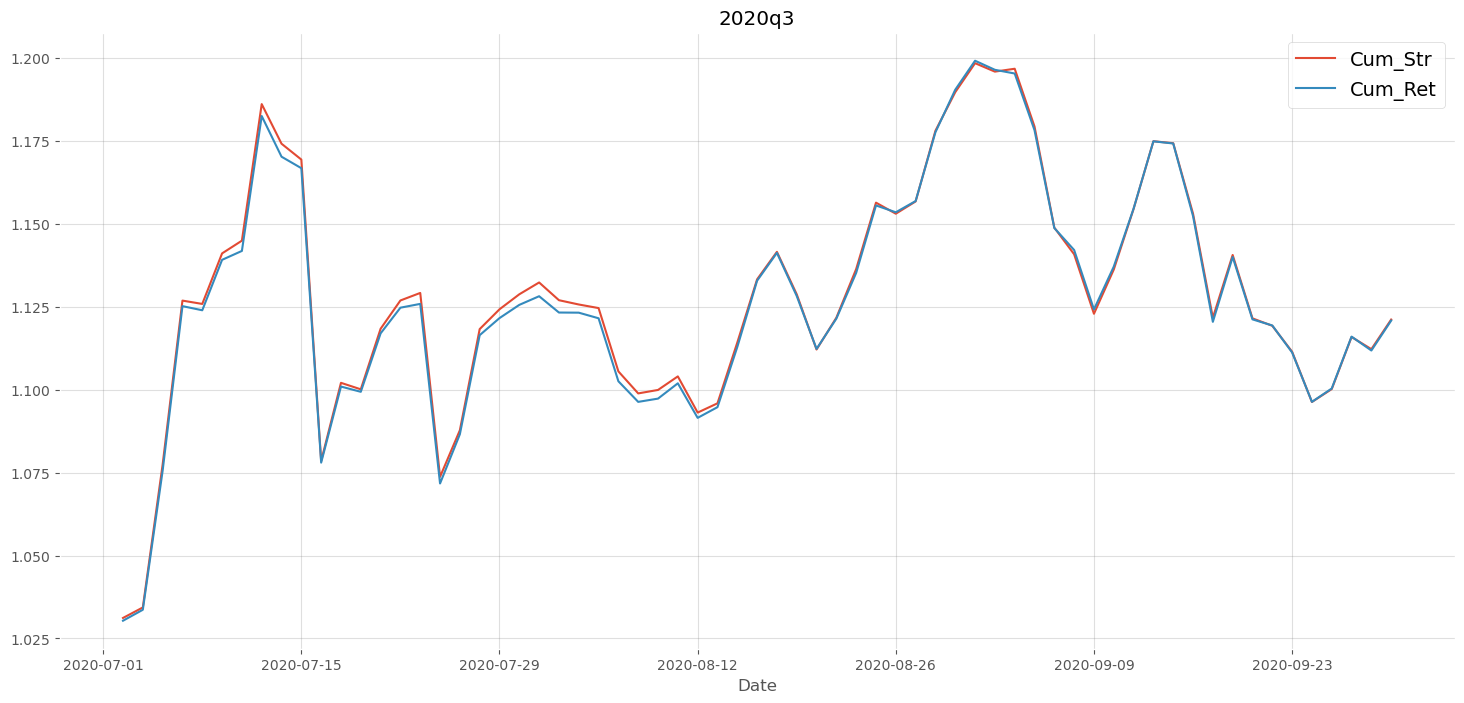

2020q4
                   a50        mom        size   portfolio   Returns  \
Date                                                                  
2020-10-09  220.732693  82.192218  360.151913  220.952379       NaN   
2020-10-12  228.434020  85.490851  372.509556  228.717112  0.034295   
2020-10-13  227.666585  86.215933  370.542626  228.022932 -0.003365   
2020-10-14  226.422437  85.910419  368.517517  226.818203 -0.005480   
2020-10-15  225.832161  84.922768  367.900771  226.121965 -0.002610   
2020-10-16  224.554742  84.656107  365.569653  224.833811 -0.005673   
2020-10-19  222.835268  83.513554  362.943975  223.032016 -0.007687   
2020-10-20  226.844474  84.698107  369.721057  227.027028  0.017832   
2020-10-21  226.801598  83.763332  369.978818  226.836337 -0.000189   
2020-10-22  227.673443  82.685859  371.680518  227.428315  0.003837   
2020-10-23  224.459364  80.685838  366.472033  224.019150 -0.014218   
2020-10-26  216.794471  79.746828  352.623194  216.489741 -0.034745   

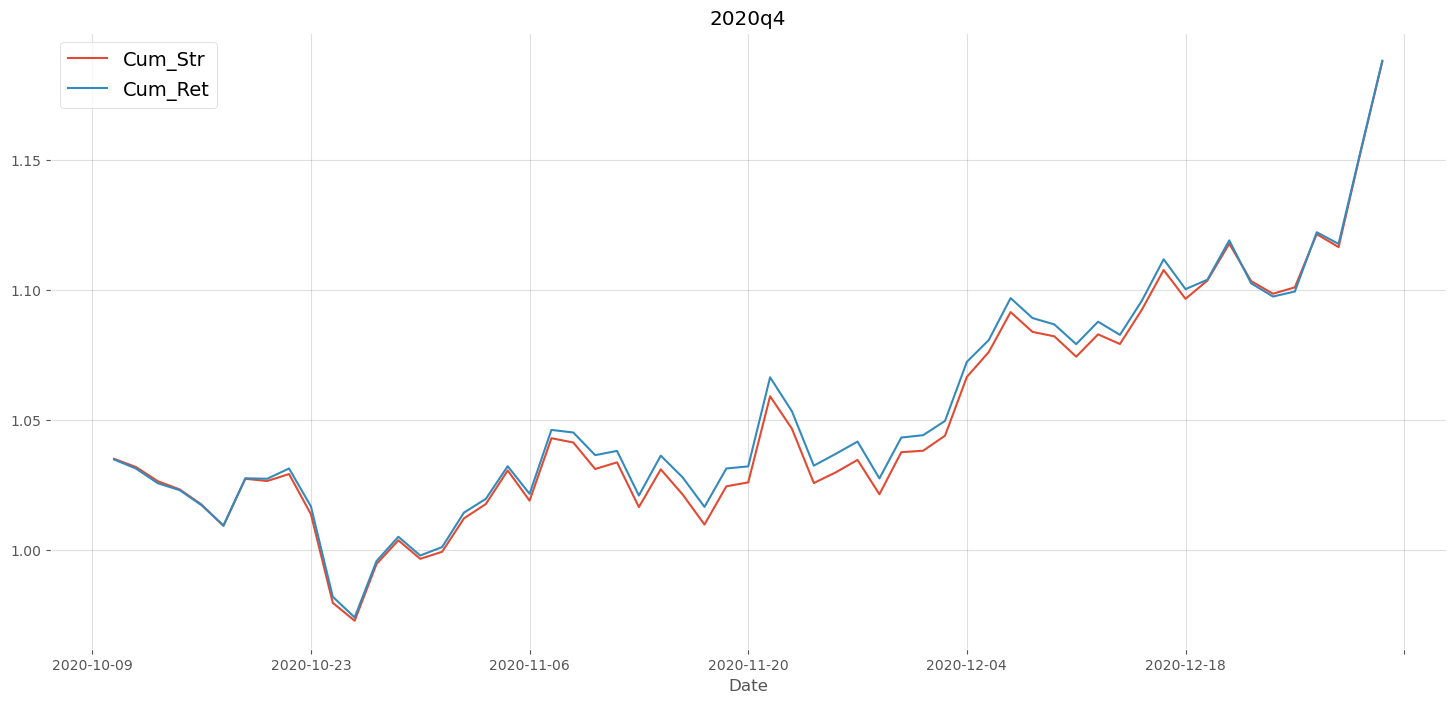

2021q1
                   a50         mom        size   portfolio   Returns  \
Date                                                                   
2021-01-04  300.714899  168.700470  496.347026  316.619323       NaN   
2021-01-05  310.267561  174.649622  511.917882  326.775657  0.031272   
2021-01-06  315.811239  174.700034  521.537686  331.965049  0.017710   
2021-01-07  322.376523  181.215170  531.777898  339.436529  0.020575   
2021-01-08  314.904414  175.824735  518.696867  331.082607 -0.023451   
2021-01-11  314.495769  172.474256  518.994888  330.115171 -0.001299   
2021-01-12  323.980940  178.140746  534.981493  340.271030  0.029714   
2021-01-13  322.827531  173.880730  533.844106  338.344974 -0.003566   
2021-01-14  316.395912  167.408723  524.045194  331.061435 -0.020124   
2021-01-15  310.580769  165.104325  513.598751  324.966153 -0.018550   
2021-01-18  308.019118  163.130083  509.182303  322.087655 -0.008282   
2021-01-19  300.667498  158.339715  497.044510  314.17980

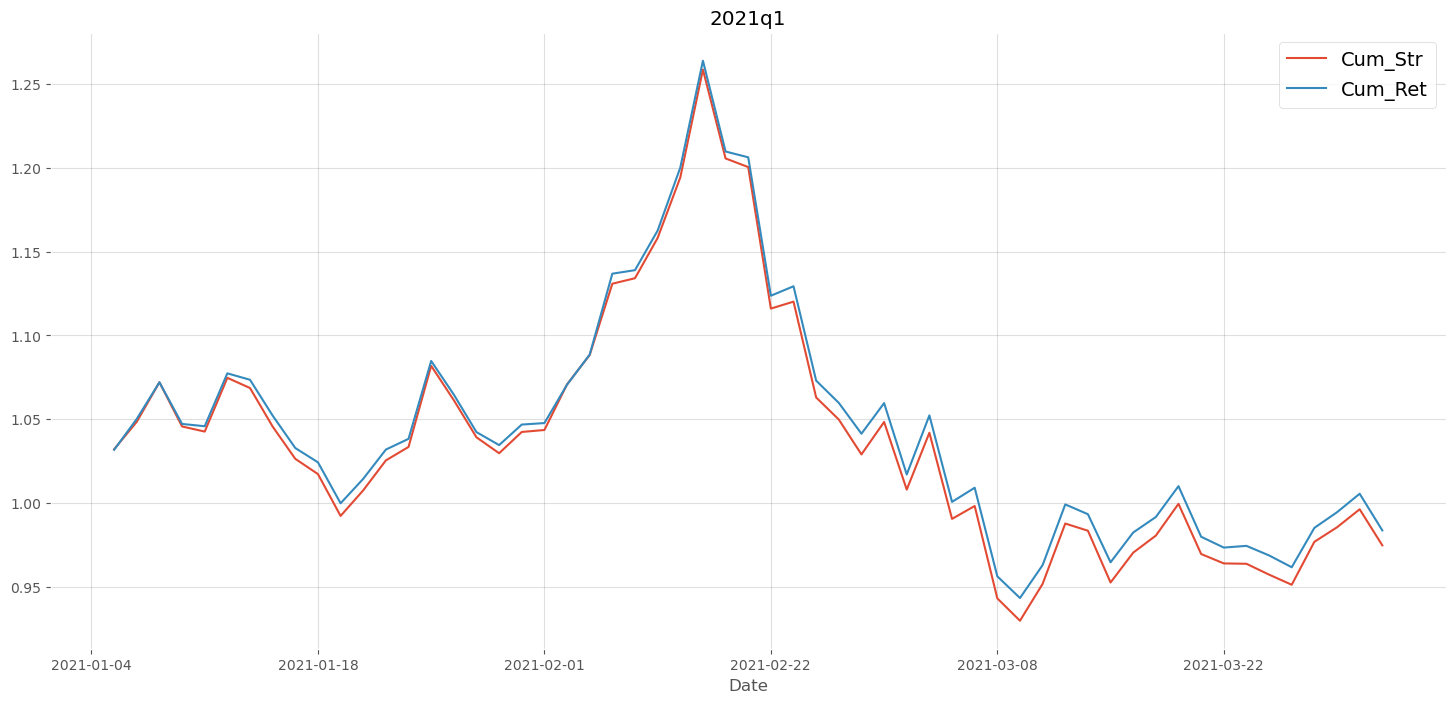

2021q2
                   a50        mom        size   portfolio   Returns  \
Date                                                                  
2021-04-01  303.091473  33.461809  504.363967  286.002181       NaN   
2021-04-02  317.990942  33.787746  530.677904  300.111884  0.047988   
2021-04-06  313.001998  33.293771  522.274000  295.392942 -0.015813   
2021-04-07  303.735595  33.133952  506.537903  286.785761 -0.030052   
2021-04-08  305.521921  33.149648  508.862015  288.263876  0.005864   
2021-04-09  297.995633  32.870900  496.540315  281.350620 -0.024943   
2021-04-12  295.708045  32.133672  493.234606  279.196092 -0.007706   
2021-04-13  296.514385  32.540540  494.173126  279.935609  0.002723   
2021-04-14  300.600799  32.460813  500.767640  283.607513  0.013687   
2021-04-15  295.888190  32.347134  492.506015  279.157382 -0.015801   
2021-04-16  300.904645  32.107292  501.552974  283.867389  0.016812   
2021-04-19  306.320561  33.224269  509.911075  288.944116  0.017839   

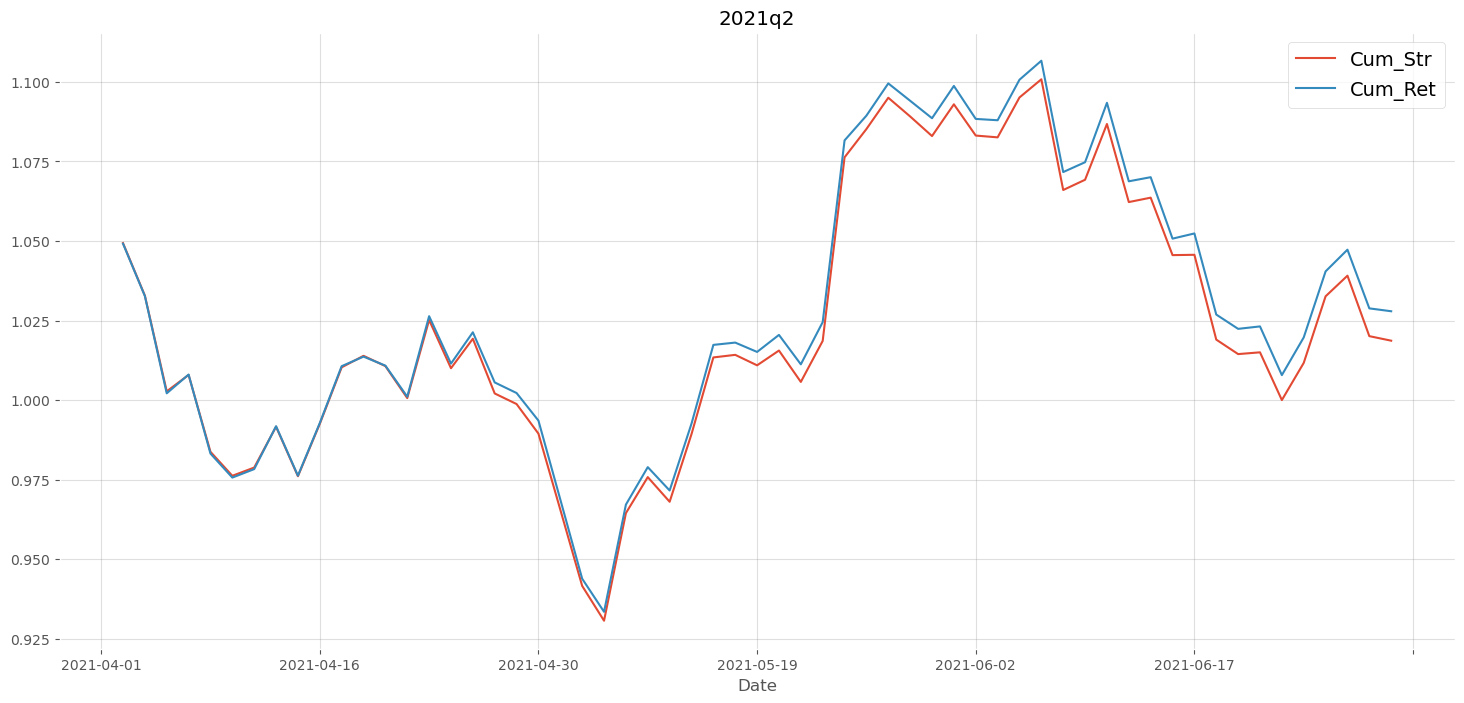

2021q3
                   a50         mom        size   portfolio   Returns  \
Date                                                                   
2021-07-01  301.683494  138.483152  505.760065  311.902551       NaN   
2021-07-02  288.762062  133.812332  484.244967  298.895356 -0.043775   
2021-07-05  287.052140  136.824245  480.516647  297.861293 -0.005939   
2021-07-06  288.760666  135.393313  484.250706  299.291338  0.005934   
2021-07-07  289.089063  139.367609  483.400280  300.236504  0.001137   
...                ...         ...         ...         ...       ...   
2021-09-24  246.126080  130.148619  408.879764  257.820136  0.030408   
2021-09-27  265.170227  132.445337  443.821769  276.651890  0.074528   
2021-09-28  261.336901  129.665047  436.660318  272.249792 -0.014562   
2021-09-29  260.784524  128.405802  435.752501  271.431838 -0.002116   
2021-09-30  262.945366  131.270171  438.863678  274.006145  0.008252   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date 

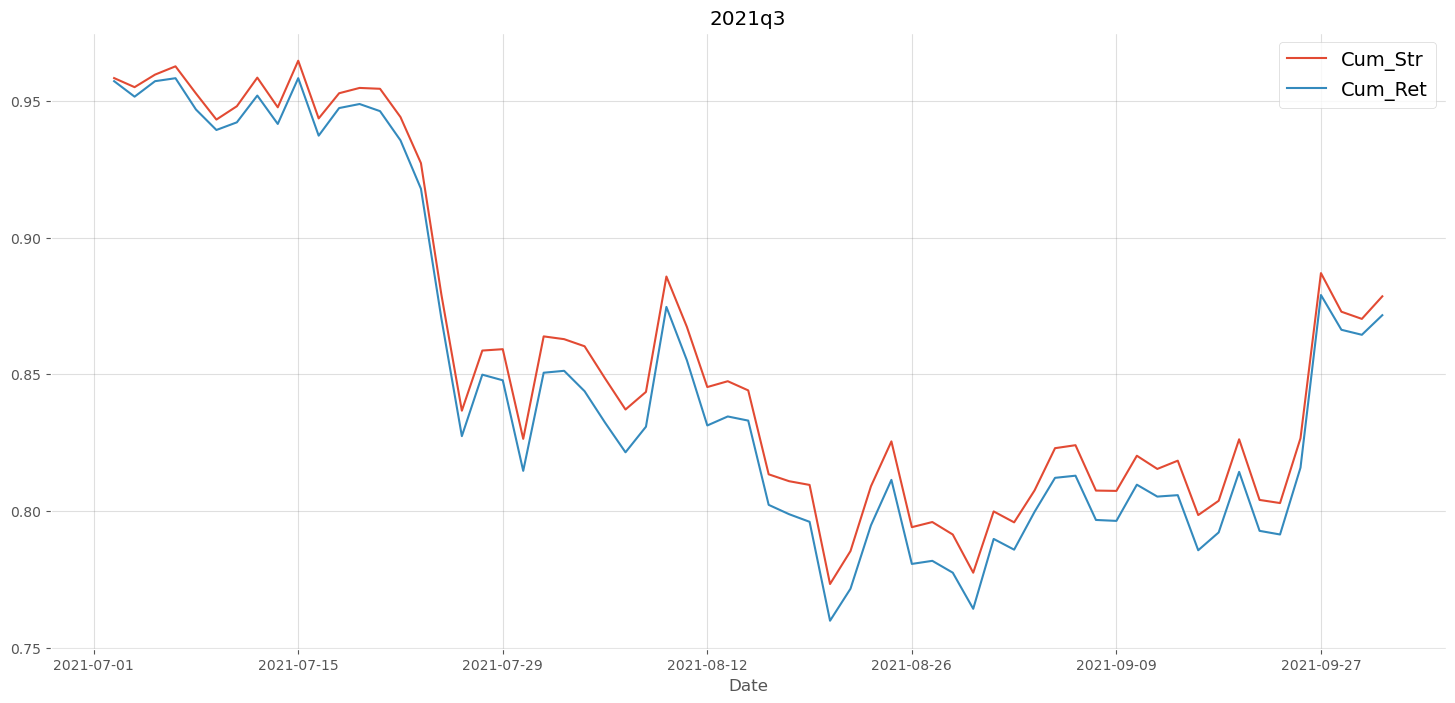

2021q4
                   a50        mom        size   portfolio   Returns  \
Date                                                                  
2021-10-08  299.883075  45.263176  484.244602  282.318482       NaN   
2021-10-11  302.861423  45.795586  491.028136  285.636642  0.009883   
2021-10-12  303.397002  45.746315  491.946799  286.121779  0.001767   
2021-10-13  313.063055  47.369485  507.606505  295.275525  0.031362   
2021-10-14  310.620448  47.754412  503.218317  293.053406 -0.007833   
...                ...        ...         ...         ...       ...   
2021-12-27  335.760581  46.597729  552.656251  317.693786 -0.022839   
2021-12-28  337.279536  47.036282  554.844917  319.110068  0.004514   
2021-12-29  323.455676  46.584862  530.847709  306.085980 -0.041850   
2021-12-30  328.224903  46.529867  538.617144  310.399204  0.014637   
2021-12-31  325.102510  46.714027  532.928915  307.461991 -0.009559   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date              

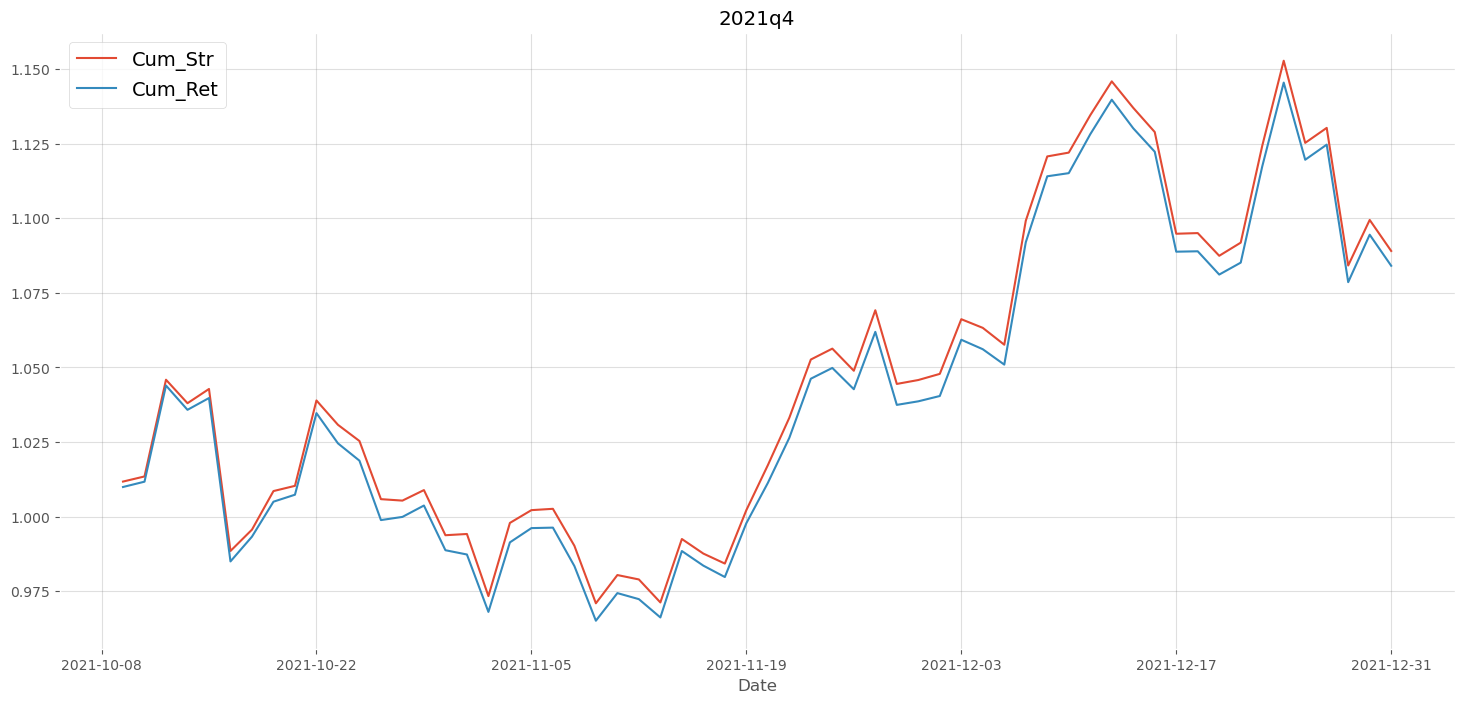

2022q1
                   a50         mom        size   portfolio   Returns  \
Date                                                                   
2022-01-04  319.749238  324.922302  518.997572  370.854587       NaN   
2022-01-05  315.321252  318.194248  511.390065  365.056704 -0.013945   
2022-01-06  309.143338  311.451243  501.315043  357.763241 -0.019787   
2022-01-07  304.097676  306.230744  492.766084  351.798045 -0.016456   
2022-01-10  306.670351  308.446668  497.594353  354.845431  0.008424   
2022-01-11  302.889153  305.046249  491.630850  350.613851 -0.012406   
2022-01-12  307.917926  309.772460  500.063375  356.417922  0.016466   
2022-01-13  296.226580  299.415263  480.044002  342.978106 -0.038709   
2022-01-14  294.877668  299.520988  477.816063  341.773097 -0.004564   
2022-01-17  295.581746  301.443051  479.275437  342.970495  0.002385   
2022-01-18  299.184969  304.453067  484.973295  346.949075  0.012117   
2022-01-19  300.071545  303.033877  487.604142  347.69527

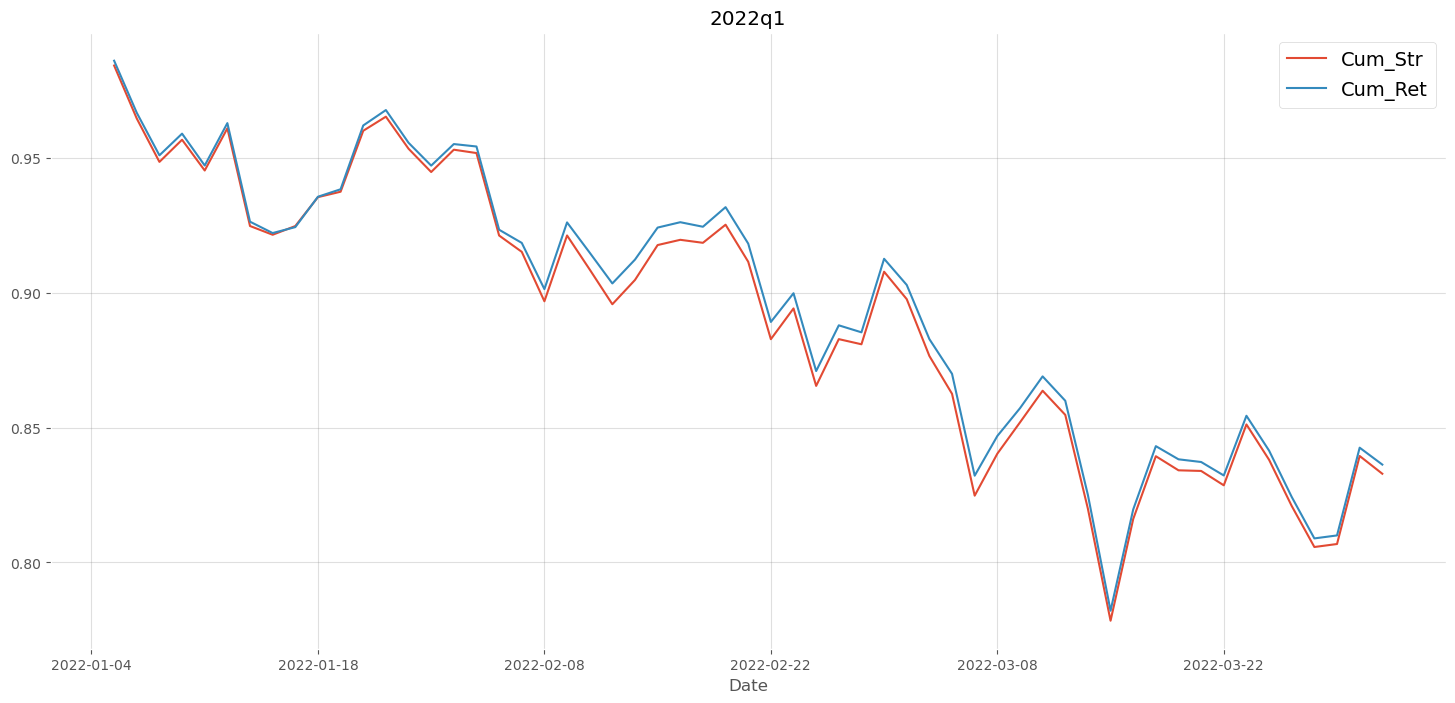

2022q2
                   a50        mom        size   portfolio   Returns  \
Date                                                                  
2022-04-01  324.428012  16.833570  634.759855  325.112362       NaN   
2022-04-06  321.448364  17.095280  629.565752  322.389440 -0.009227   
2022-04-07  320.861542  16.807970  628.622709  321.788441 -0.001827   
2022-04-08  323.730047  16.904823  635.009386  324.843576  0.008900   
2022-04-11  312.020576  17.438406  611.743712  313.305817 -0.036841   
2022-04-12  323.479675  17.416349  633.404038  324.444934  0.036067   
2022-04-13  321.316484  17.297038  628.850766  322.195193 -0.006710   
2022-04-14  328.368501  16.121224  641.899513  328.689435  0.021710   
2022-04-15  327.605295  16.012688  640.678755  327.975508 -0.002327   
2022-04-18  324.971120  15.637965  635.363100  325.235826 -0.008073   
2022-04-19  323.982590  15.472383  634.116063  324.388406 -0.003047   
2022-04-20  323.124270  15.131276  632.155878  323.383924 -0.002653   

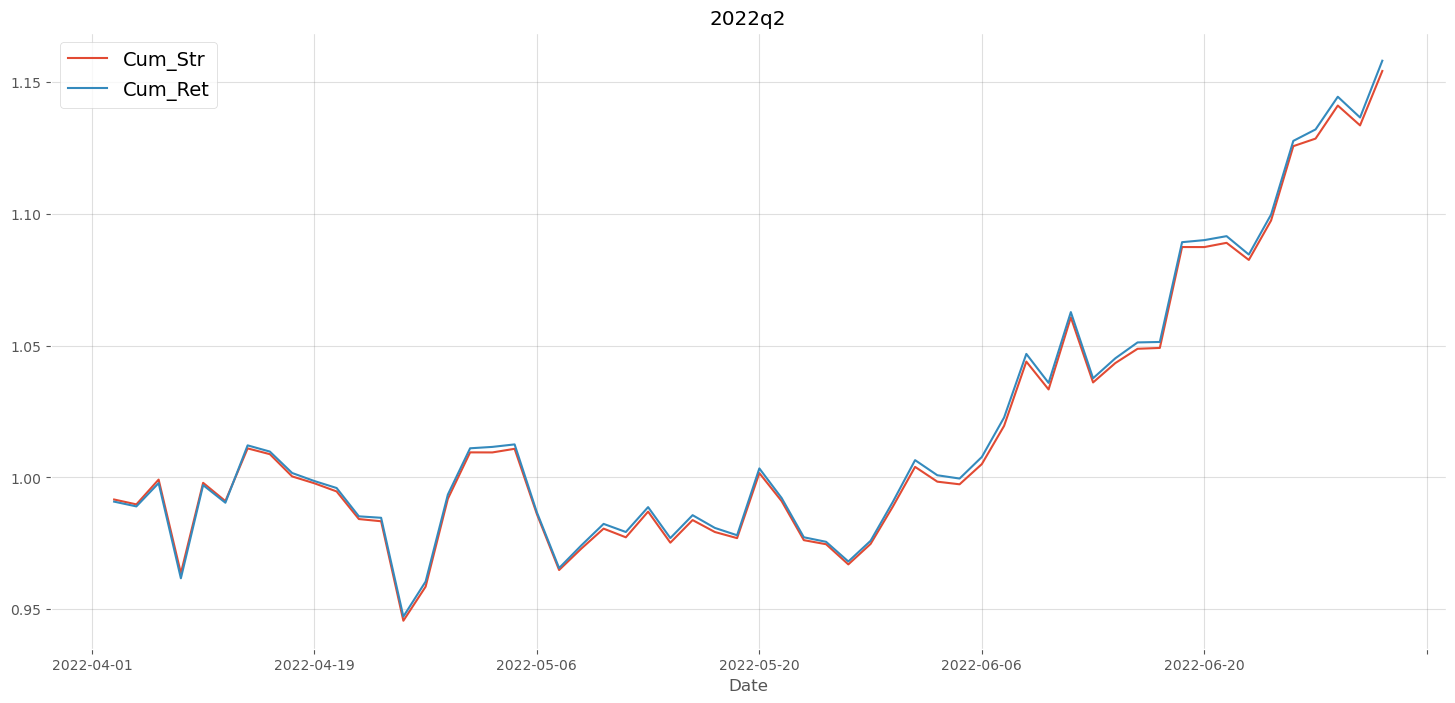

2022q3
                   a50         mom        size   portfolio   Returns  \
Date                                                                   
2022-07-01  387.874653  165.306204  744.581087  421.409150       NaN   
2022-07-04  387.047024  165.600613  742.532521  420.556796 -0.002136   
2022-07-05  389.066327  164.485835  746.703829  422.330580  0.005204   
2022-07-06  382.971104  161.014222  735.535024  415.622863 -0.015790   
2022-07-07  382.356912  162.145031  734.370922  415.307444 -0.001605   
...                ...         ...         ...         ...       ...   
2022-09-26  349.510531  142.768553  673.153776  378.735848  0.015838   
2022-09-27  355.026919  146.582413  683.036954  384.918301  0.015660   
2022-09-28  353.349144  145.031763  679.883788  382.903460 -0.004737   
2022-09-29  353.172228  144.451595  679.329448  382.531375 -0.000501   
2022-09-30  350.971024  142.719171  674.801453  379.865668 -0.006252   

            Strategy_Returns   Cum_Ret   Cum_Str  
Date 

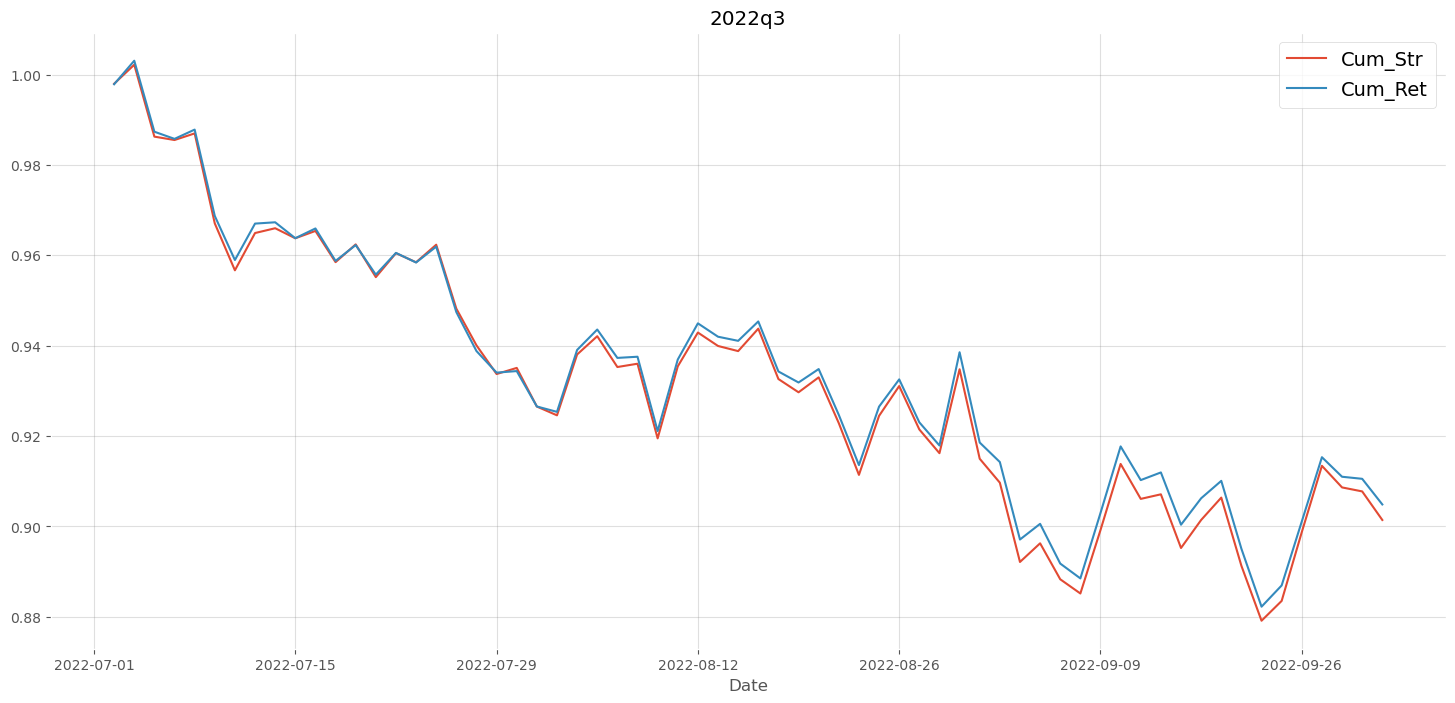

2022q4
                   a50        mom        size   portfolio   Returns  \
Date                                                                  
2022-10-10  304.555073  13.455033  601.594805  306.039996       NaN   
2022-10-11  304.959621  13.376953  602.096607  306.348201  0.001327   
2022-10-12  303.228389  13.486784  598.383535  304.581774 -0.005693   
2022-10-13  294.600301  13.300933  580.234755  295.684073 -0.028867   
2022-10-14  302.092632  13.334531  595.260099  303.194974  0.025114   
2022-10-17  298.686409  13.251494  588.290898  299.728803 -0.011339   
2022-10-18  297.444192  13.260555  585.933504  298.520611 -0.004168   
2022-10-19  288.494440  13.062285  568.229199  289.570091 -0.030551   
2022-10-20  287.230119  12.934081  565.331016  288.181333 -0.004392   
2022-10-21  284.298667  12.994918  559.542413  285.283666 -0.010258   
2022-10-24  265.437888  12.683828  521.656322  266.303981 -0.068644   
2022-10-25  262.440949  12.622954  515.285466  263.197580 -0.011355   

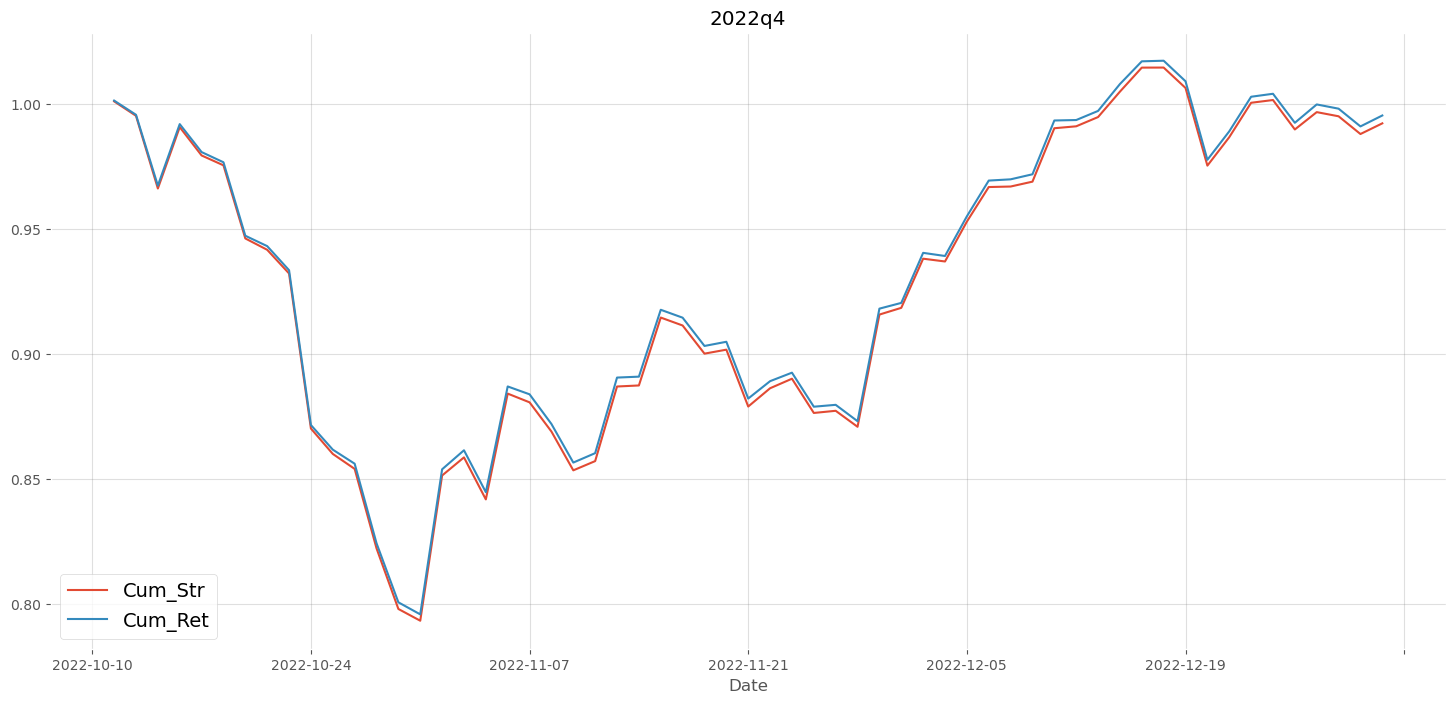

2023q1
                   a50        mom        size   portfolio   Returns  \
Date                                                                  
2023-01-03  316.360501  67.249687  604.391575  326.090566       NaN   
2023-01-04  315.679827  67.832696  602.979107  325.542864 -0.002154   
2023-01-05  329.121733  70.811602  628.976657  339.507931  0.041699   
2023-01-06  330.006362  70.797457  630.699218  340.377350  0.002684   
2023-01-09  335.822869  71.875639  642.037338  346.389678  0.017472   
2023-01-10  338.677623  72.086684  647.906278  349.337052  0.008465   
2023-01-11  337.011727  71.915876  644.705122  347.661113 -0.004931   
2023-01-12  335.916144  71.636947  642.235285  346.426130 -0.003256   
2023-01-13  344.902559  73.044284  659.455210  355.576153  0.026400   
2023-01-16  350.093276  75.191159  668.856054  361.058441  0.014938   
2023-01-17  348.666407  74.258791  666.478289  359.517473 -0.004084   
2023-01-18  346.381449  74.288983  662.401277  357.363289 -0.006575   

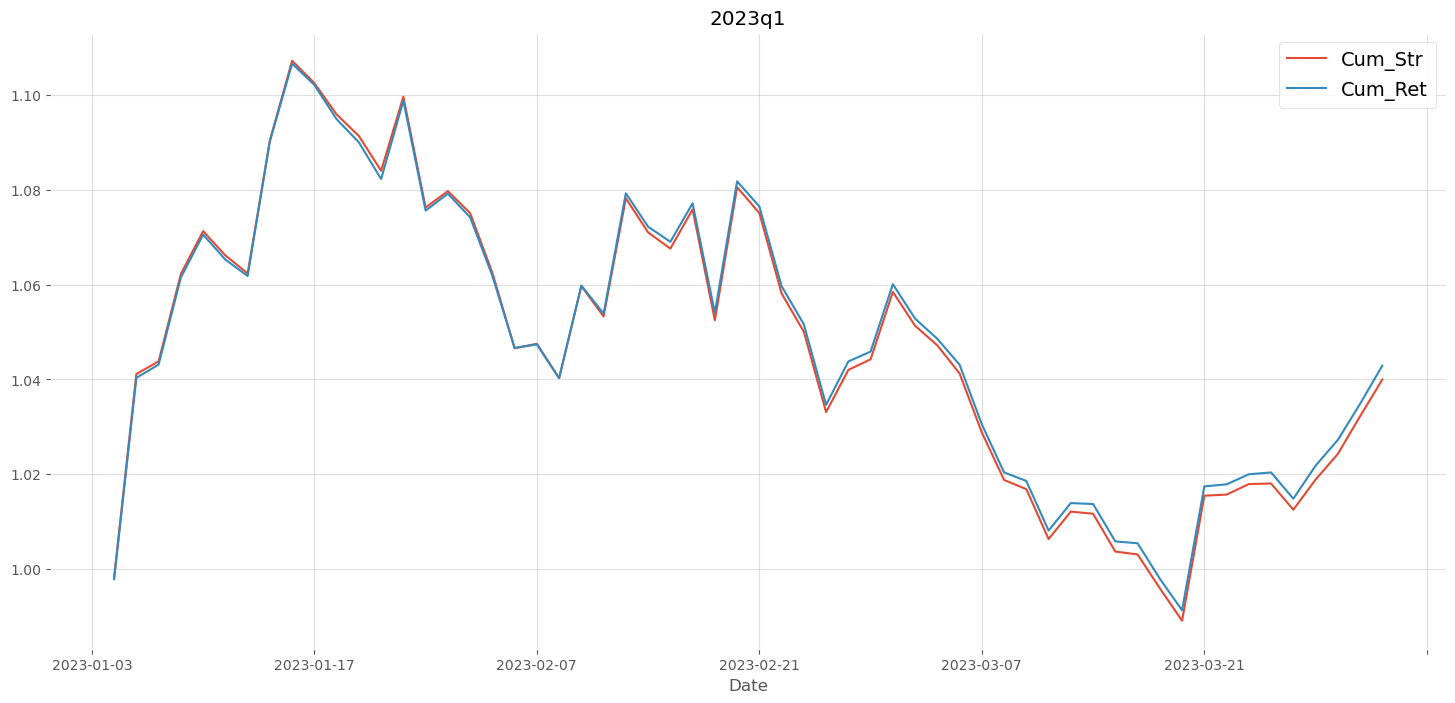

2023q2
                   a50        mom        size   portfolio   Returns  \
Date                                                                  
2023-04-03  333.543638  70.849848  666.425646  351.090692       NaN   
2023-04-04  334.864288  71.422711  669.258103  352.602348  0.003952   
2023-04-06  331.436266  69.897424  662.532344  348.825575 -0.010290   
2023-04-07  330.861328  69.351735  661.233263  348.076913 -0.001736   
2023-04-10  328.107714  68.530746  655.822559  345.142183 -0.008357   
2023-04-11  323.665914  67.228044  646.456929  340.254200 -0.013630   
2023-04-12  315.134343  65.998784  628.603866  331.217834 -0.026713   
2023-04-13  319.524768  66.391753  637.732236  335.793381  0.013836   
2023-04-14  318.238031  65.710231  635.109924  334.324054 -0.004035   
2023-04-17  325.118357  66.892690  649.274343  341.600937  0.021390   
2023-04-18  326.021557  67.042449  651.123554  342.552279  0.002774   
2023-04-19  325.882164  66.481818  651.298351  342.386124 -0.000428   

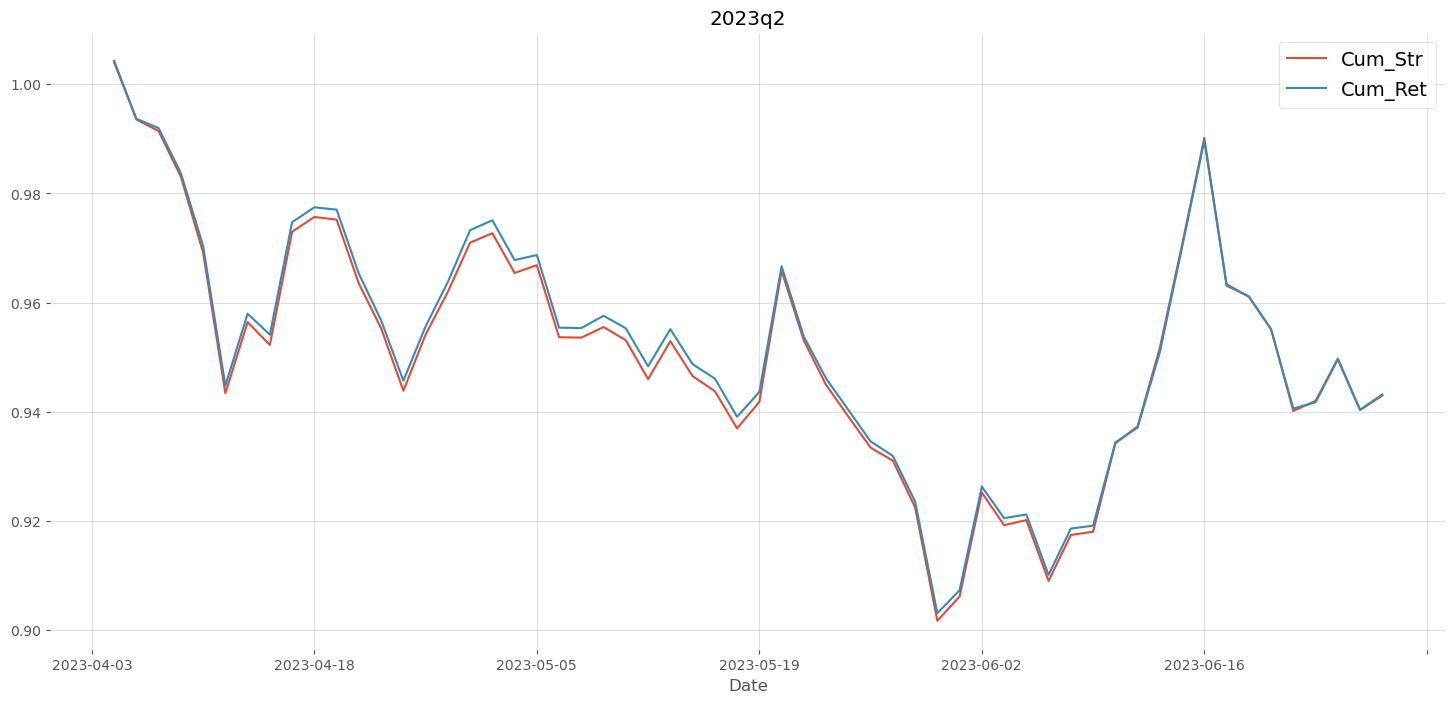

In [5]:
# loop through all quarters and visualize returns of our portfolios

dict_all = {}
for name in df_weights['Time'].sort_values(ascending=True).unique()[1:]:
    df = get_return(name,df_weights,df_data,mom_number_comp,size_number_comp,dic_factor_weights)
    dict_all[name] = df
    print(name)
    print(df)
    df[['Cum_Str','Cum_Ret']].plot(figsize=[18,8],title=name)
    plt.show()

In [6]:
# form returns dataframe including A50 strategy index

dict_summary = {"A50_Return":[],"Strategy_Return":[],"Index_Return":[]}

for name in list(dict_all.keys()):
    dict_summary["A50_Return"].append(dict_all[name]["Cum_Ret"][-1])
    dict_summary["Strategy_Return"].append(dict_all[name]["Cum_Str"][-1])
    df_index = pd.DataFrame()
    df_index["price"] = get_index(name,df_weights,df_data)
    df_index["index_return"] = np.log(df_index["price"] / df_index["price"].shift(1))
    df_index["Cum_index_Ret"] = df_index["index_return"].cumsum().apply(np.exp)
    dict_summary["Index_Return"].append(df_index["Cum_index_Ret"][-1])

df_summary = pd.DataFrame(dict_summary).set_index(df_weights["Time"].sort_values(ascending=True).unique()[1:])
df_summary.tail(5)

,A50_Return,Strategy_Return,Index_Return
2022q2,1.157959,1.154069,1.063121
2022q3,0.904857,0.901418,0.845156
2022q4,0.995366,0.992220,1.030928
2023q1,1.042904,1.039973,1.018336
2023q2,0.943176,0.942969,0.963155


In [7]:
df_summary["Index_Return"].prod()

1.3178667721401058

<Axes: title={'center': 'A50 Cum Index'}, xlabel='Date'>

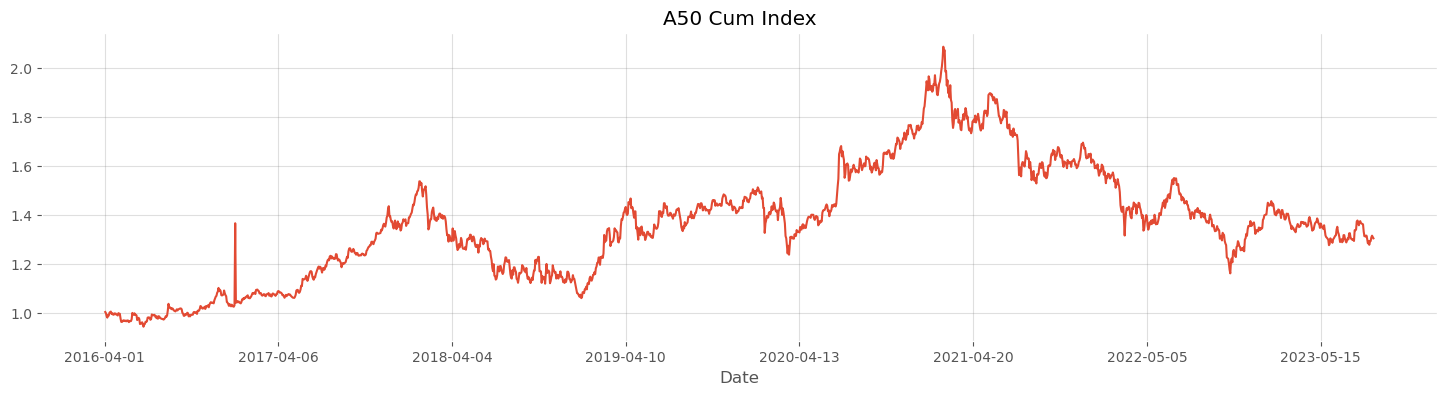

In [8]:
# plot the true A50 Index
A50_Index_df = pd.DataFrame()
A50_Index_df["price"] = df_data["Price"].loc[:"2016-04-01"].sort_index(ascending = True)
A50_Index_df["Index Return"] = np.log(A50_Index_df["price"] / A50_Index_df["price"].shift(1))
A50_Index_df["Cum Index"] = A50_Index_df["Index Return"].cumsum().apply(np.exp)
A50_Index_df['Cum Index'].plot(title = "A50 Cum Index", figsize=[18,4])

<Axes: title={'center': 'Strategy Return vs Index Return'}>

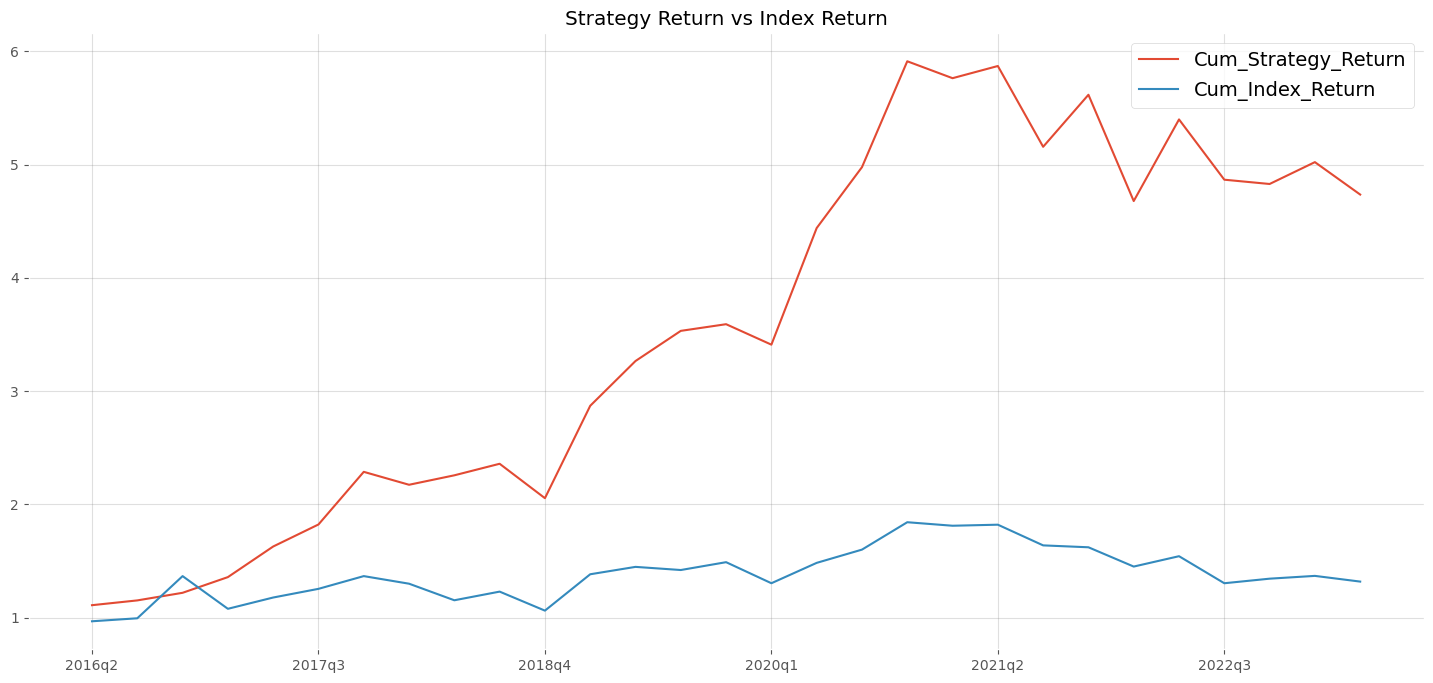

In [9]:
# compare our BBoss ETF against true A50 Index Returns
# there is a significant beat in Alpha
df_summary['Cum_Strategy_Return'] = df_summary['Strategy_Return'].cumprod()
df_summary['Cum_Index_Return']= df_summary['Index_Return'].cumprod()

## Combine the two plots with common x-axis
df_summary[['Cum_Strategy_Return','Cum_Index_Return']].plot(title = "Strategy Return vs Index Return", figsize=(18,8))

### Exploratory Data Analysis

- Run some stats on BBoss_ETF vs Index_df to set baseline for `A50_Return`, `Strategy_Returns`, `Index_Return`, and pass into dict_summary { }. 
- Work out formulas for `Alpha`, `Beta`, `Sharpe`, `Sortino`,`drawdown` and pass the results into dict_summary.  
- Assume `risk-free rate = 2.00%`(RMB), quarterly rate is 0.50% per quarter. Analyse the alpha/beta of Alpha Strategy for first half (`2016-2020`) 

Text(0.5, 0, 'Market Return')

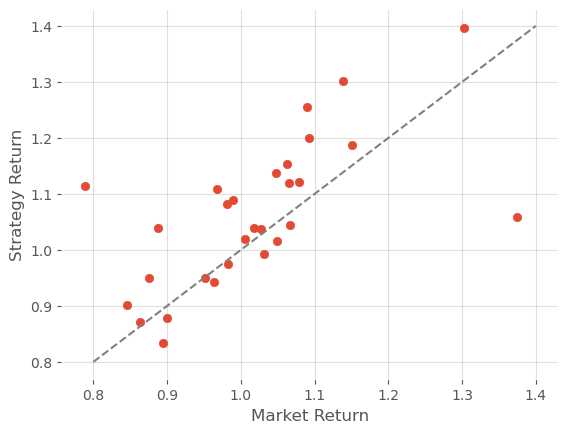

In [10]:
plt.scatter(df_summary['Index_Return'],df_summary['Strategy_Return'])
x = np.linspace(0.80, 1.40, 100)
plt.plot(x, x, linestyle='--', color='gray')

plt.ylabel('Strategy Return')
plt.xlabel('Market Return')

In [11]:
import statsmodels.api as sm

In [12]:
# do analysis on our portfolio

rf = 0.02/4
#Alpha Strategy Pre-Covid (2016 to 2020q1)
market_return = df_summary['Index_Return'][df_summary.index<'2020q2'] - rf
strategy_return = df_summary['Strategy_Return'][df_summary.index<'2020q2'] - rf
ols_model = sm.OLS(strategy_return,sm.add_constant(market_return))
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Strategy_Return   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     6.107
Date:                Sat, 21 Oct 2023   Prob (F-statistic):             0.0269
Time:                        12:47:48   Log-Likelihood:                 13.846
No. Observations:                  16   AIC:                            -23.69
Df Residuals:                      14   BIC:                            -22.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6143      0.191      3.217      0.006       0.205       1.024
Index_Return     0.4571      0.185      2.471      0.027       0.060       0.854
==============================================================================
Omnibus:                        0.306   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.858   Jarque-Bera (JB):                0.458
Skew:                           0.051   Prob(JB):                        0.795
Kurtosis:                       2.177   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Analysis

- Write up analysis from OLS Regression, going through significance of each test stats. Calculate different performance ratios: Sharpe , Sortino. 


In [13]:
df_summary_qlog = pd.DataFrame()
df_summary_qlog = df_summary - 1
df_summary_qlog = df_summary_qlog.drop('Cum_Strategy_Return',axis=1)
df_summary_qlog.describe()

,A50_Return,Strategy_Return,Index_Return,Cum_Index_Return
count,29.000000,29.000000,29.000000,29.000000
mean,0.062690,0.062630,0.016870,0.383800
std,0.130181,0.130230,0.126770,0.230947
min,-0.163692,-0.167089,-0.211325,-0.032566
25%,-0.016334,-0.025261,-0.049064,0.253847
50%,0.043465,0.045192,0.018336,0.366294
75%,0.120785,0.121096,0.066295,0.489309
max,0.405421,0.397137,0.374736,0.842151


In [20]:
Rf=0.02
df_summary_qlog['R_Index - Rf'] = df_summary_qlog['Index_Return'] - Rf
df_summary_qlog['R_Strategy - Rf'] = df_summary_qlog['Strategy_Return'] - Rf
# df_summary_qlog

dict_Ri_Rf = {}
dict_Ri_Rf['R_Index - Rf'] = df_summary_qlog['R_Index - Rf']
dict_Ri_Rf['R_Strategy - Rf'] = df_summary_qlog['R_Strategy - Rf']
# dict_Ri_Rf

# calculate sharpe ratio
dict_sharpe = {}
dict_sharpe = {'A50_Return':[],'Strategy_Return':[],'Index_Return':[]}
for name in list(dict_summary.keys()):
    sharpe = np.sqrt(4)*(df_summary_qlog[name].mean()/df_summary_qlog[name].std())
    dict_sharpe[name].append(sharpe)
df_sharpe = pd.DataFrame(dict_sharpe) 

# calculate sortina ratio
dict_sortino = {}
dict_sortino = {'R_Strategy - Rf':[],'R_Index - Rf':[]}
for name in list(dict_Ri_Rf.keys()):
    Emean = df_summary_qlog[name].mean()
    df_summary_qlog[name] = df_summary_qlog[name].apply(lambda x: x if x > 0 else 0)
    df_summary_qlog[name] = df_summary_qlog[name]**2
    sv = df_summary_qlog[name].mean()
    Sortino = (Emean/(sv**0.5))
    dict_sortino[name].append(Sortino)
df_sortino = pd.DataFrame(dict_sortino) 
df_sortino = df_sortino.rename(columns={'R_Strategy - Rf': 'Strategy',
                                        'R_Index - Rf': 'Index'})

# calculate drawdown
df_total = get_return('2016q2',df_weights,df_data,mom_number_comp,size_number_comp,dic_factor_weights)

#all returns
list_df_summary_index = df_summary.index.tolist()
for i in range(1,len(df_summary)):
    df_quarter = get_return(list_df_summary_index[i],df_weights,df_data,mom_number_comp,size_number_comp,dic_factor_weights)
    df_total = pd.concat([df_total, df_quarter], axis=0)
df_total

# fill NaN
df_total = df_total.ffill()
df_total["Index_cumulative_returns"]= df_total["Returns"].cumsum()
df_total["Strategy_cumulative_returns"]= df_total["Strategy_Returns"].cumsum()
df_total["Index_max_gross_performance"] = df_total["Index_cumulative_returns"].cummax()
df_total["Strategy_max_gross_performance"] = df_total["Strategy_cumulative_returns"].cummax()

drawdown_Index = df_total["Index_max_gross_performance"] - df_total["Index_cumulative_returns"]
drawdown_Strategy = df_total["Strategy_max_gross_performance"] - df_total["Strategy_cumulative_returns"]

# put the ratios together
df_sharpe = df_sharpe.iloc[:,1:]
df_sharpe = df_sharpe.rename(columns={'Strategy_Return': 'Strategy','Index_Return': 'Index'})
df_performance = pd.concat([df_sharpe, df_sortino], axis=0)
df_performance.index = ['Sharpe Ratio','Sortino Ratio']
df_performance.loc["Max DrawDown",:] = [drawdown_Strategy.max(),drawdown_Index.max()]
df_performance


,Strategy,Index
Sharpe Ratio,0.961844,0.266152
Sortino Ratio,0.355200,-0.033173
Max DrawDown,0.676379,0.659410
